In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import time
import seaborn as sns
import psutil
import cv2

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)        

1 Physical GPUs, 1 Logical GPUs


# Data Preprocessing

In [ ]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
train_balanced=pd.read_csv("emnist-balanced-train.csv",header=None)
test_balanced=pd.read_csv("emnist-balanced-test.csv",header=None)

In [ ]:
s_alph=list(string.ascii_uppercase)
l_alph=list(string.ascii_uppercase)

excluded_letters = ['c','i','j','k','m','o','p','q','s','u','v','w','x','y','z']  # 제외할 알파벳 리스트, balanced의 구성에 따라서

l_alph = list(string.ascii_lowercase)
filtered_l_alph = [letter for letter in l_alph if letter not in excluded_letters]

number = [str(i) for i in range(10)]
balanced_classes=np.transpose(number+s_alph+filtered_l_alph)
print(balanced_classes) 



['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'd' 'e' 'f' 'g' 'h' 'l' 'n' 'r' 't']


In [ ]:
train_balanced.shape

(112800, 785)

In [ ]:
 # data label 나누기
X_train = train_balanced.iloc[:, 1:].to_numpy()
train_labels = np.transpose(balanced_classes[train_balanced.iloc[:,0].tolist()])
X_test = test_balanced.iloc[:, 1:].to_numpy()
test_labels = np.transpose(balanced_classes[test_balanced.iloc[:,0].tolist()])

In [ ]:
train_labels.shape

(112800,)

In [ ]:
# 이미지 회전 함수
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])

In [ ]:
# 전체 이미지 회전 및 teonsor 형태로 변환
X_train = (np.apply_along_axis(rotate, 1, X_train)/255).reshape(-1, 28, 28, 1).astype(float)
X_test = (np.apply_along_axis(rotate, 1, X_test)/255).reshape(-1, 28, 28, 1).astype(float)

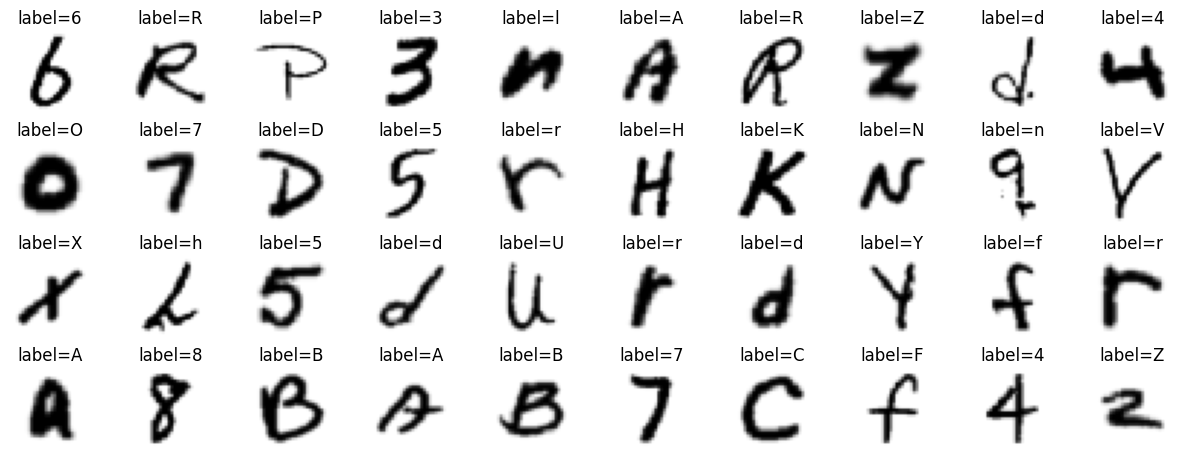

In [ ]:
plt.figure(figsize=(15,6))
for i in range(80,120):  
    plt.subplot(4, 10, i+1-80)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={train_labels[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

In [ ]:
uppercase_classes = ['A','B','D','E','F','G','H','L','N','R','T']
lowercase_classes = ['a','b','d','e','f','g','h','l','n','r','t']

#['c','i','j','k','m','o','p','q','s','u','v','w','x','y','z'] 제외
# 대문자와 소문자에 해당하는 클래스 인덱스 가져오기
uppercase_indices_train = np.where(np.isin(train_labels, uppercase_classes))[0]
lowercase_indices_train = np.where(np.isin(train_labels, lowercase_classes))[0]

# 대문자와 소문자에 해당하는 데이터와 레이블 추출
x_train_uppercase = X_train[uppercase_indices_train]
y_train_uppercase = train_labels[uppercase_indices_train]
x_train_lowercase = X_train[lowercase_indices_train]
y_train_lowercase = train_labels[lowercase_indices_train]

#테스트 셋에 적용
uppercase_indices_test = np.where(np.isin(test_labels, uppercase_classes))[0]
lowercase_indices_test = np.where(np.isin(test_labels, lowercase_classes))[0]

# 대문자와 소문자에 해당하는 데이터와 레이블 추출
x_test_uppercase = X_test[uppercase_indices_test]
y_test_uppercase = test_labels[uppercase_indices_test]
x_test_lowercase = X_test[lowercase_indices_test]
y_test_lowercase = test_labels[lowercase_indices_test]

In [ ]:
print(x_train_uppercase.shape)
print(y_train_lowercase.shape)
print(x_test_lowercase.shape)
print(y_test_lowercase.shape)

(26400, 28, 28, 1)
(26400,)
(4400, 28, 28, 1)
(4400,)


In [ ]:
lowercase_indices_train

array([     0,      1,      2, ..., 112778, 112786, 112787], dtype=int64)

In [ ]:
# 대문자와 소문자 데이터 병합
x_train_combined = np.concatenate((x_train_uppercase, x_train_lowercase), axis=0)
y_train_combined = np.concatenate((y_train_uppercase, y_train_lowercase), axis=0)

x_test_combined = np.concatenate((x_test_uppercase, x_test_lowercase), axis=0)
y_test_combined = np.concatenate((y_test_uppercase, y_test_lowercase), axis=0)

In [ ]:
# one-hot coding
y_train = pd.get_dummies(y_train_combined).to_numpy()
y_test = pd.get_dummies(y_test_combined).to_numpy()

In [ ]:
y_train.shape

(52800, 22)

In [ ]:
y_train[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [ ]:
integer_data_list = []
integet_data_list_test=[]
for one_hot_data in y_train:
    integer_data = np.argmax(one_hot_data)
    integer_data_list.append(integer_data)
    
for one_hot_data in y_test:
    integer_data = np.argmax(one_hot_data)
    integet_data_list_test.append(integer_data)

y_train=integer_data_list
y_train=np.array(y_train)
y_test=integet_data_list_test
y_test=np.array(y_test)

In [ ]:
import numpy as np

def label_data(data):
    labels = []
    for item in data:
        if item<=11:  # 소문자인 경우
            labels.append(0)  # 라벨 0
        else:  # 대문자인 경우
            labels.append(1)  # 라벨 1
    return np.array(labels)

# 데이터에 라벨 할당
labels_train = label_data(y_train)

def label_data_test(data):
    labels_test = []
    for item in data:
        if item<=11:  # 소문자인 경우
            labels_test.append(0)  # 라벨 0
        else:  # 대문자인 경우
            labels_test.append(1)  # 라벨 1
    return np.array(labels_test)

labels_test=label_data_test(y_test)
print(labels_train)
print(labels_test)

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [ ]:
print(labels_train.shape)
print(labels_test.shape)

(52800,)
(8800,)


In [ ]:
num=0
for i in labels_train:
    if(i==0):
        num=num+1
print(num)

28800


In [ ]:
# 모델 구성
# Define simplified LeNet-5 
from tensorflow import keras
tf.random.set_seed(42)
tf.keras.backend.clear_session()

model= keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),
    keras.layers.Conv2D(6, kernel_size = 5, padding = 'same', activation = "relu", strides = 1),
    keras.layers.MaxPool2D(strides = 2),
    keras.layers.Conv2D(16, kernel_size = 5, activation = "relu", strides = 1),
    keras.layers.MaxPool2D(strides = 2),
    keras.layers.Conv2D(120, kernel_size = 5, activation = "relu", strides = 1),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation="relu"),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(84, activation="relu"),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(2, activation="softmax")
])


In [ ]:
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
checkpoint_dir = './model_resnet_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)
callbacks_list = [ES, MCP, RLP]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(labels_train.reshape(-1, 1))
y_test = encoder.fit_transform(labels_test.reshape(-1, 1))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(x_train_combined, y_train,stratify=y_train, test_size=0.1,random_state=42)

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
x_test_combined.shape

(8800, 28, 28, 1)

In [ ]:
y_train.shape

(47520, 2)

In [ ]:
# 모델 훈련
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=40, batch_size=64,callbacks=callbacks_list)

Epoch 1/40
738/743 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8726
Epoch 1: val_loss improved from inf to 0.18518, saving model to ./model_resnet_checkpoint\cp-01-0.1852.ckpt
743/743 [==============================] - 3s 4ms/step - loss: 0.2937 - accuracy: 0.8729 - val_loss: 0.1852 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 2/40
737/743 [============================>.] - ETA: 0s - loss: 0.1754 - accuracy: 0.9299
Epoch 2: val_loss improved from 0.18518 to 0.16787, saving model to ./model_resnet_checkpoint\cp-02-0.1679.ckpt
743/743 [==============================] - 3s 4ms/step - loss: 0.1755 - accuracy: 0.9299 - val_loss: 0.1679 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 3/40
732/743 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9383
Epoch 3: val_loss improved from 0.16787 to 0.16118, saving model to ./model_resnet_checkpoint\cp-03-0.1612.ckpt
743/743 [==============================] - 3s 4ms/step - loss: 0.1545 - accuracy: 0.9383 - v

In [ ]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

275/275 [==============================] - 1s 2ms/step - loss: 0.1631 - accuracy: 0.9353
Test Loss: 0.16312463581562042
Test Accuracy: 0.9353408813476562


In [ ]:
model.save('my_model.h5')

# 모델을 이용해 데이터 선별 및 삭제

In [ ]:
loaded_model = keras.models.load_model('my_model.h5')

In [ ]:
train_byclass=pd.read_csv("emnist-byclass-train.csv",header=None)
test_byclass=pd.read_csv("emnist-byclass-test.csv",header=None)

In [ ]:
train_byclass.shape

(697932, 785)

In [ ]:
s_alph=list(string.ascii_uppercase)
l_alph = list(string.ascii_lowercase)
number = [str(i) for i in range(10)]

byclass_classes=np.transpose(number+s_alph+l_alph)
print(byclass_classes) 

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
#넘파이 형식으로 바꾸기 + 라벨 추출하기
X_train_byclass = train_byclass.iloc[:, 1:].to_numpy()
train_labels_byclass = np.transpose(byclass_classes[train_byclass.iloc[:,0].tolist()])
X_test_byclass = test_byclass.iloc[:, 1:].to_numpy()
test_labels_byclass = np.transpose(byclass_classes[test_byclass.iloc[:,0].tolist()])

In [ ]:
X_train_byclass.shape

(697932, 784)

In [ ]:
train_labels_byclass.shape

(697932,)

In [ ]:
# 전체 이미지 회전 및 teonsor 형태로 변환
X_train_byclass = (np.apply_along_axis(rotate, 1, X_train_byclass)/255).reshape(-1, 28, 28, 1).astype(float)
X_test_byclass = (np.apply_along_axis(rotate, 1, X_test_byclass)/255).reshape(-1, 28, 28, 1).astype(float)

In [ ]:
#전체 데이터에 대한 정렬(대소문자 데이터만 처리하기 위해 슬라이싱을 해야함.)

sorted_indices = np.argsort(train_labels_byclass)
labels_sorted=train_labels_byclass[sorted_indices]
X_train_byclass_sorted=X_train_byclass[sorted_indices]

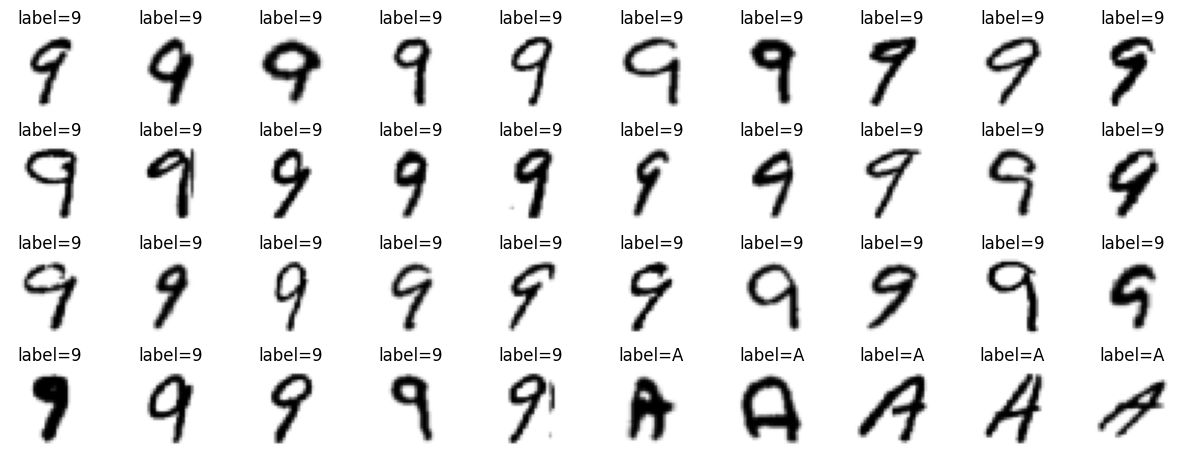

In [ ]:
plt.figure(figsize=(15,6))
for i in range(345000,345040):  
    plt.subplot(4, 10, i+1-345000)
    plt.imshow(X_train_byclass_sorted[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={labels_sorted[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

#육안으로는 대문자(혹은 소문자)인데 그 반대의 것으로 라벨링된 데이터가 다수 발견됨.
#

#인덱스 345,035까지 숫자 데이터, 이후는 문자 데이터

In [ ]:
#테스트셋에 대해 같은 작업 수행

sorted_indices_test = np.argsort(test_labels_byclass)
labels_sorted_test=test_labels_byclass[sorted_indices_test]
X_test_byclass_sorted=X_test_byclass[sorted_indices_test]

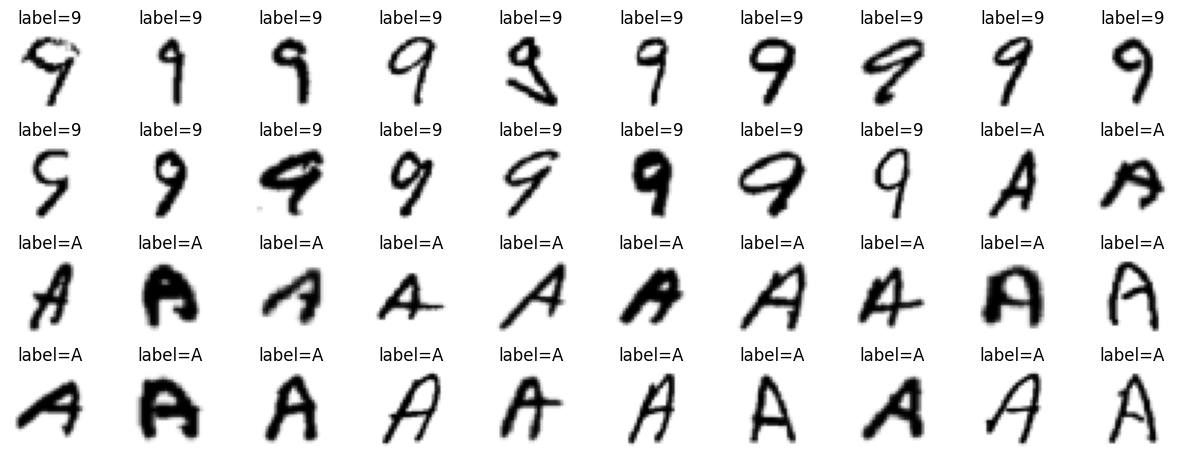

In [ ]:
plt.figure(figsize=(15,6))
for i in range(57900,57940):  
    plt.subplot(4, 10, i+1-57900)
    plt.imshow(X_test_byclass_sorted[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={labels_sorted_test[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

#육안으로는 대문자(혹은 소문자)인데 그 반대의 것으로 라벨링된 데이터가 다수 발견됨.
#57,918까지 숫자 데이터, 이후는 문자 데이터

In [ ]:
x_train_number=X_train_byclass_sorted[:345035]
x_train_characters=X_train_byclass_sorted[345035:]

y_train_number=labels_sorted[:345035]
y_train_characters=labels_sorted[345035:]


x_test_number=X_test_byclass_sorted[:57918]
x_test_characters=X_train_byclass_sorted[57918:]

y_test_number=labels_sorted_test[:57918]
y_test_characters=labels_sorted_test[57918:]

In [ ]:
uppercase_classes = ['A','B','D','E','F','G','H','L','N','R']
#A,B,D,E,F,G,H,L,M,N

lowercase_classes = ['a','b','d','e','f','g','h','l','n','r']

excluded_classes=['C','I','J','K','M','O','P','Q','S','T','U','V','W','X','Y','Z',
                 'c','i','j','k','m','o','p','q','s','t','u','v','w','x','y','z']

# 대문자와 소문자에 해당하는 데이터와 레이블 추출(트레인)
uppercase_indices_train = np.where(np.isin(y_train_characters, uppercase_classes))[0]
lowercase_indices_train = np.where(np.isin(y_train_characters, lowercase_classes))[0]
excluded_indices_train=np.where(np.isin(y_train_characters,excluded_classes))[0]


x_train_uppercase = x_train_characters[uppercase_indices_train]
y_train_uppercase = y_train_characters[uppercase_indices_train]
x_train_lowercase = x_train_characters[lowercase_indices_train]
y_train_lowercase = y_train_characters[lowercase_indices_train]
x_train_excluded=x_train_characters[excluded_indices_train]
y_train_excluded=y_train_characters[excluded_indices_train]


# 대문자와 소문자에 해당하는 데이터와 레이블 추출(테스트)
uppercase_indices_test = np.where(np.isin(y_test_characters, uppercase_classes))[0]
lowercase_indices_test = np.where(np.isin(y_test_characters, lowercase_classes))[0]
excluded_indices_test=np.where(np.isin(y_test_characters,excluded_classes))[0]


x_test_uppercase = x_test_characters[uppercase_indices_test]
y_test_uppercase = y_test_characters[uppercase_indices_test]
x_test_lowercase = x_test_characters[lowercase_indices_test]
y_test_lowercase = y_test_characters[lowercase_indices_test]
x_test_excluded=x_test_characters[excluded_indices_test]
y_test_excluded=y_test_characters[excluded_indices_test]

In [ ]:
print(x_train_uppercase.shape)
print(x_train_lowercase.shape)
print(x_train_excluded.shape)

print(x_test_uppercase.shape)
print(x_test_lowercase.shape)
print(x_test_excluded.shape)

(53018, 28, 28, 1)
(105827, 28, 28, 1)
(194052, 28, 28, 1)
(8718, 28, 28, 1)
(17493, 28, 28, 1)
(32194, 28, 28, 1)


In [ ]:
y_train_uppercase[0]

'A'

In [ ]:
print(53018+105827+194052+345035) #해당 값이 byclass_train의 데이터 수와 같아야 함.
#같음.

697932


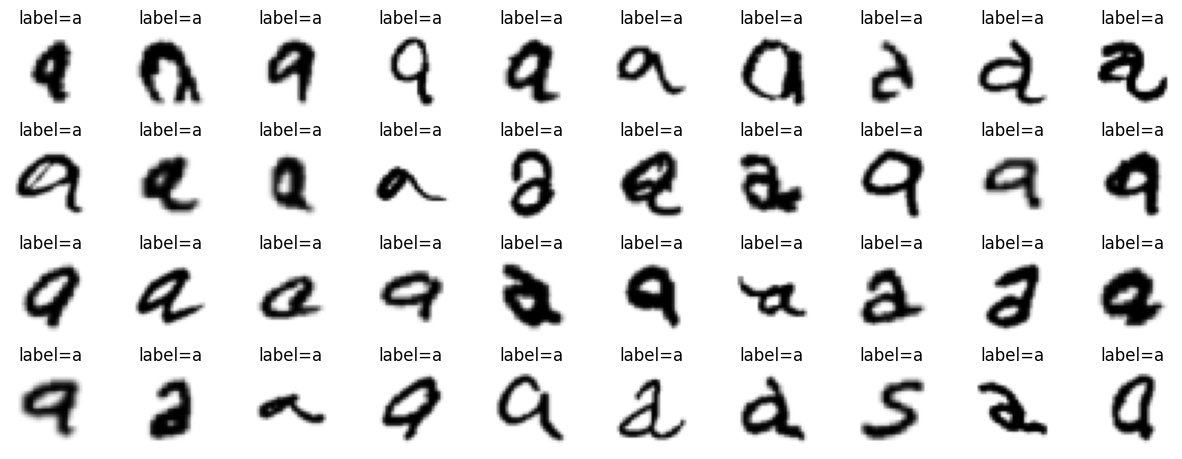

In [ ]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(x_train_lowercase[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={y_train_lowercase[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

In [ ]:
prediction_upper=(loaded_model.predict(x_train_uppercase))
prediction_lower=(loaded_model.predict(x_train_lowercase))
prediction_excluded=(loaded_model.predict(x_train_excluded))

6065/6065 [==============================] - 5s 819us/step


In [ ]:
prediction_upper=np.argmax(prediction_upper,axis=1)
prediction_lower=np.argmax(prediction_lower,axis=1)
prediction_excluded=np.argmax(prediction_excluded,axis=1)

In [ ]:
num=0

indices_to_delete_upper = []
for i in range(len(prediction_upper)):
    if(prediction_upper[i]==1):
        indices_to_delete_upper.append(i)
x_train_uppercase=np.delete(x_train_uppercase,indices_to_delete_upper,axis=0)
y_train_uppercase=np.delete(y_train_uppercase,indices_to_delete_upper,axis=0)
print(len(indices_to_delete_upper))

#출력된 수는 제외되는 데이터의 수임.

3374


In [ ]:
num=0

indices_to_delete_lower = []
for i in range(len(prediction_lower)):
    if(prediction_lower[i]==0):
        indices_to_delete_lower.append(i)

x_train_lowercase=np.delete(x_train_lowercase,indices_to_delete_lower,axis=0)
y_train_lowercase=np.delete(y_train_lowercase,indices_to_delete_lower,axis=0)
print(len(indices_to_delete_lower))

28080


In [ ]:
print(x_train_uppercase.shape)
print(y_train_uppercase.shape)

(49644, 28, 28, 1)
(49644,)


In [ ]:
print(x_train_lowercase.shape)
print(y_train_lowercase.shape)

(77747, 28, 28, 1)
(77747,)


In [ ]:
prediction_upper_test=(loaded_model.predict(x_test_uppercase))
prediction_lower_test=(loaded_model.predict(x_test_lowercase))
prediction_excluded_test=(loaded_model.predict(x_test_excluded))

1007/1007 [==============================] - 1s 978us/step


In [ ]:
prediction_upper_test=np.argmax(prediction_upper_test,axis=1)
prediction_lower_test=np.argmax(prediction_lower_test,axis=1)
prediction_excluded_test=np.argmax(prediction_excluded_test,axis=1)

#원-핫 인코딩을 해야하기 때문에, argmax 함수를 이용함.

In [ ]:
num=0

indices_to_delete_upper_test = []
for i in range(len(prediction_upper_test)):
    if(prediction_upper_test[i]==1):
        indices_to_delete_upper_test.append(i)
x_test_uppercase=np.delete(x_test_uppercase,indices_to_delete_upper_test,axis=0)
y_test_uppercase=np.delete(y_test_uppercase,indices_to_delete_upper_test,axis=0)
print(len(indices_to_delete_upper_test))

342


In [ ]:
num=0

indices_to_delete_lower_test = []
for i in range(len(prediction_lower_test)):
    if(prediction_lower_test[i]==1):
        indices_to_delete_lower_test.append(i)
x_test_lowercase=np.delete(x_test_lowercase,indices_to_delete_lower_test,axis=0)
y_test_lowercase=np.delete(y_test_lowercase,indices_to_delete_lower_test,axis=0)
print(len(indices_to_delete_lower_test))

5103


In [ ]:
X_byclass_train=np.concatenate((x_train_number,x_train_uppercase,x_train_lowercase,x_train_excluded))
y_byclass_train=np.concatenate((y_train_number,y_train_uppercase,y_train_lowercase,y_train_excluded))
X_byclass_test=np.concatenate((x_test_number,x_test_uppercase,x_test_lowercase,x_test_excluded))
y_byclass_test=np.concatenate((y_test_number,y_test_uppercase,y_test_lowercase,y_test_excluded))

In [ ]:
print(X_byclass_train.shape)
print(y_byclass_train.shape)
print(X_byclass_test.shape)
print(y_byclass_test.shape)

(666478, 28, 28, 1)
(666478,)
(110878, 28, 28, 1)
(110878,)


In [ ]:
#테스트셋을 건드렸기 때문에 전체 데이터에 대해 셔플을 진행함.
X_byclass_union=np.concatenate((X_byclass_train,X_byclass_test))
y_byclass_union=np.concatenate((y_byclass_train,y_byclass_test))

indices_x = np.arange(len(X_byclass_union))


np.random.shuffle(indices_x)


X_byclass_union=X_byclass_union[indices_x]
y_byclass_union=y_byclass_union[indices_x]

y_byclass_union = pd.get_dummies(y_byclass_union).to_numpy()

In [ ]:
print(X_byclass_union.shape)
print(y_byclass_union.shape)

(777356, 28, 28, 1)
(777356, 62)


In [ ]:
#69만개의 트레인셋, 나머지는 테스트셋으로 사용.
X_byclass_train,y_byclass_train= X_byclass_union[:690000],y_byclass_union[:690000]
X_byclass_test,y_byclass_test=X_byclass_union[690000:],y_byclass_union[690000:]

In [ ]:
print(X_byclass_train.shape)
print(y_byclass_train.shape)
print(X_byclass_test.shape)
print(y_byclass_test.shape)

(690000, 28, 28, 1)
(690000, 62)
(87356, 28, 28, 1)
(87356, 62)


In [ ]:
y_byclass_union[45]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
#원핫 인코딩을 위한 준비과정

integer_data_list = []

for one_hot_data in y_byclass_union:
    integer_data = np.argmax(one_hot_data)
    integer_data_list.append(integer_data)

y_train=integer_data_list
y_train=np.array(y_train)

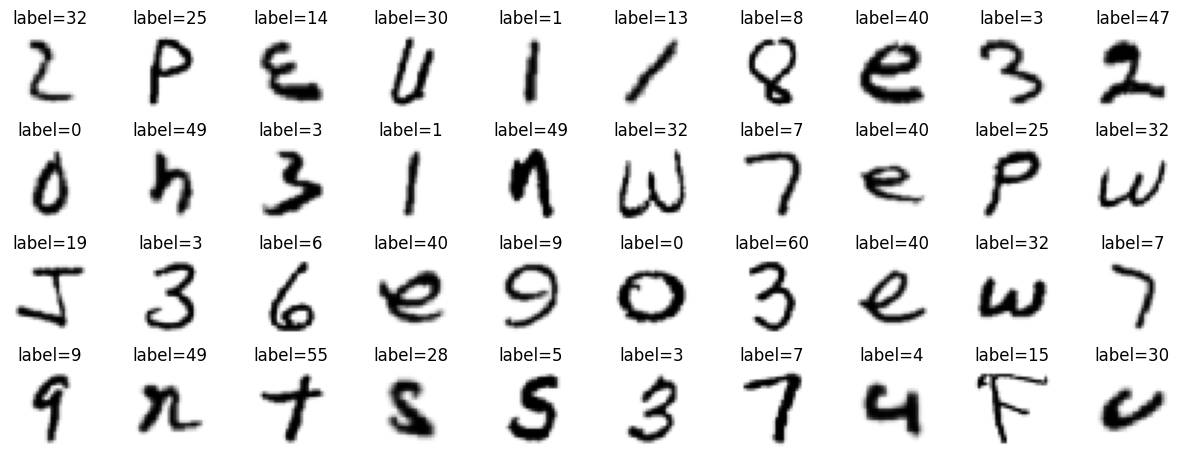

In [ ]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_byclass_union[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={y_train[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

In [ ]:
np.save('X_byclass_train.npy', X_byclass_train)
np.save('y_byclass_train.npy', y_byclass_train)
np.save('X_byclass_test.npy', X_byclass_test)
np.save('y_byclass_test.npy',y_byclass_test)

#데이터를 npy로 저장

# 기존 byclass 데이터에 대한 성능체크

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import time
import seaborn as sns
import psutil
import cv2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)        

1 Physical GPUs, 1 Logical GPUs


In [ ]:
train_byclass = pd.read_csv('emnist-byclass-train.csv', header=None)
test_byclass = pd.read_csv('emnist-byclass-test.csv', header=None)

In [ ]:
s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+l_alph+s_alph)
print(byclass_classes) 

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
 # data label 나누기
X_train = train_byclass.iloc[:, 1:].to_numpy()
train_labels = np.transpose(byclass_classes[train_byclass.iloc[:,0].tolist()])
X_test = test_byclass.iloc[:, 1:].to_numpy()
test_labels = np.transpose(byclass_classes[test_byclass.iloc[:,0].tolist()])

In [ ]:
# one-hot coding
y_train = pd.get_dummies(train_labels).to_numpy()
y_test = pd.get_dummies(test_labels).to_numpy()

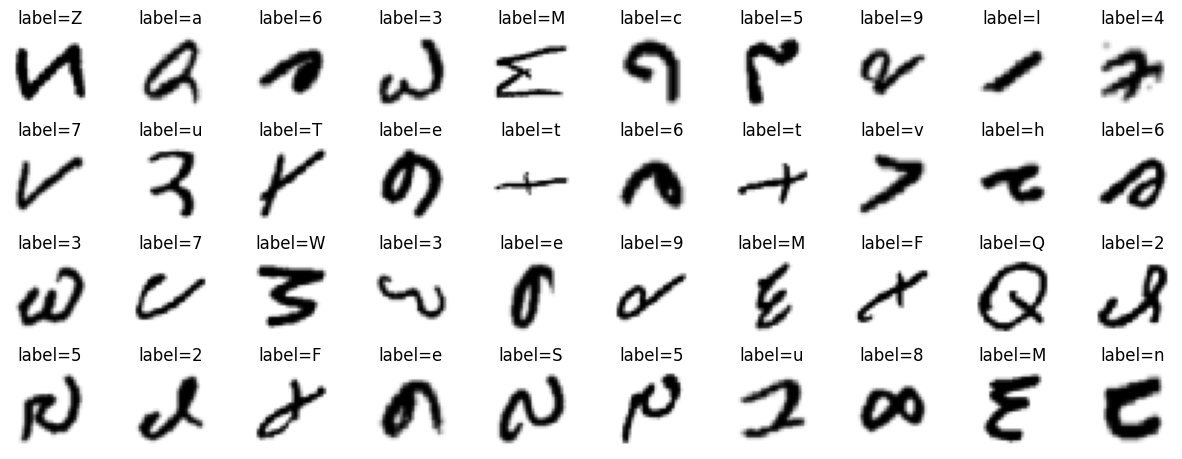

In [ ]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title(f'label={train_labels[i]}', y=1)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)
plt.show()

In [ ]:
# 전체 이미지 회전 및 teonsor 형태로 변환
X_train = ((X_train)/255).reshape(-1, 28, 28, 1).astype(float)
X_test = ((X_test)/255).reshape(-1, 28, 28, 1).astype(float)

In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)

In [ ]:
del train_byclass, test_byclass, byclass_classes, train_labels, test_labels

# LeNet5 BaseLine

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense
from tensorflow.keras.layers import SeparableConv2D, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from itertools import product

In [ ]:
class LeNet : 
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        model.add(Conv2D(32, kernel_size = 5, padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
        model.add(Conv2D(48, kernel_size = 5, padding="valid"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
        model.add(Flatten())
        model.add(Dense(300))
        model.add(Activation("relu"))
        model.add(Dense(100))
        BatchNormalization()
        Dropout(rate=0.5)
        model.add(Activation("relu"))
        model.add(Dense(62))
        BatchNormalization()
        Dropout(rate=0.5)
        model.add(Activation("softmax"))
        return model

In [ ]:
model_LeNet = LeNet.build(input_shape = (28, 28, 1), classes = 62)

In [ ]:
model_LeNet = LeNet.build(input_shape = (28, 28, 1), classes = 62)

ES = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
checkpoint_dir = './model_resnet_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)
callbacks_list = [ES, MCP, RLP]

In [ ]:
model_LeNet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# baseline LeNet5 under sampling class 별 약 1800개

start = time.time()

history = model_LeNet.fit(X_train, y_train ,epochs=20,batch_size=64,
                          verbose=1, validation_data=(X_val,y_val),callbacks=callbacks_list)
LeNet_train_time = time.time()-start
print("training time : ", time.time()-start, "s")

#전처리한 데이터의 성능을 비교하는 것이 목표이기 때문에,
#파인튜닝은 최소화 하였음.

Epoch 1/20
9270/9270 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.8327
Epoch 1: val_loss improved from inf to 0.39624, saving model to ./model_resnet_checkpoint\cp-01-0.3962.ckpt
9270/9270 [==============================] - 27s 3ms/step - loss: 0.4837 - accuracy: 0.8327 - val_loss: 0.3962 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 2/20
9256/9270 [============================>.] - ETA: 0s - loss: 0.3754 - accuracy: 0.8612
Epoch 2: val_loss improved from 0.39624 to 0.37251, saving model to ./model_resnet_checkpoint\cp-02-0.3725.ckpt
9270/9270 [==============================] - 29s 3ms/step - loss: 0.3753 - accuracy: 0.8612 - val_loss: 0.3725 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 3/20
9257/9270 [============================>.] - ETA: 0s - loss: 0.3512 - accuracy: 0.8679
Epoch 3: val_loss improved from 0.37251 to 0.37071, saving model to ./model_resnet_checkpoint\cp-03-0.3707.ckpt
9270/9270 [==============================] - 29s 3ms/step - loss: 0.3512 - accur

In [ ]:
#tf.keras.models.save_model(path+"LeNet.h5")

start = time.time()
print(model_LeNet.evaluate(X_test,y_test))

LeNet_test_time = time.time()-start
print("inference time : ",  time.time()-start, "s")

#byclass 데이터에 대한 인퍼런스 점수

3636/3636 [==============================] - 5s 2ms/step - loss: 0.3633 - accuracy: 0.8666
[0.3633437752723694, 0.866629958152771]
inference time :  6.063655376434326 s


In [ ]:
inference_byclass = pd.read_csv('my_emnist_gu.csv', header=None)
inference_byclass1 = pd.read_csv('my_emnist _lss(2).csv', header=None)
inference_byclass2 = pd.read_csv('sjw_hand (1).csv', header=None)
inference_byclass3 = pd.read_csv('my_emnist_ssh.csv', header=None)
inference_byclass = pd.concat([inference_byclass, inference_byclass1,inference_byclass2,inference_byclass3 ], axis=0)

In [ ]:
s_alph=list(string.ascii_uppercase)
l_alph = list(string.ascii_lowercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+s_alph+l_alph)
print(byclass_classes) 

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
# data label 나누기
X_inference = inference_byclass.iloc[:, 1:].to_numpy()
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])

In [ ]:
# 이미지 회전 함수
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])

In [ ]:
# 전체 이미지 회전 및 teonsor 형태로 변환
X_test_hand = (np.apply_along_axis(rotate, 1, X_inference)/255).reshape(-1, 28, 28, 1).astype(float)

In [ ]:
print(X_test_hand.shape)
print(inference_labels.shape)

(2480, 28, 28, 1)
(2480,)


In [ ]:
y_test_hand = pd.get_dummies(inference_labels).to_numpy()

In [ ]:
print(model_LeNet.evaluate(X_test_hand,y_test_hand))
#byclass 데이터셋으로 학습시킨 모델에 대한,

78/78 [==============================] - 0s 2ms/step - loss: 1.1092 - accuracy: 0.6516
[1.1091737747192383, 0.6516128778457642]


# Preprocessing Data로 학습 및 base line Lenet-5로 검증

In [ ]:
X_train=np.load("X_byclass_train.npy")
X_test=np.load("X_byclass_test.npy")
y_train=np.load("y_byclass_train.npy")
y_test=np.load("y_byclass_test.npy")

In [ ]:
X_train.shape

(690000, 28, 28, 1)

In [ ]:
y_test.shape

(87356, 62)

In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense
from tensorflow.keras.layers import SeparableConv2D, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from itertools import product

In [ ]:
class LeNet : 
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        model.add(Conv2D(32, kernel_size = 5, padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
        model.add(Conv2D(48, kernel_size = 5, padding="valid"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
        model.add(Flatten())
        model.add(Dense(300))
        model.add(Activation("relu"))
        BatchNormalization()
        Dropout(rate=0.5)
        model.add(Dense(100))
        model.add(Activation("relu"))
        BatchNormalization()
        Dropout(rate=0.5)
        model.add(BatchNormalization())
        model.add(Dense(62))
        model.add(Activation("softmax"))
        return model

In [ ]:
model_LeNet = LeNet.build(input_shape = (28, 28, 1), classes = 62)

ES = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
checkpoint_dir = './model_resnet_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)
callbacks_list = [ES, MCP, RLP]

In [ ]:
model_LeNet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# baseline LeNet5 under sampling class 별 약 1800개

start = time.time()

history = model_LeNet.fit(X_train, y_train ,epochs=20,batch_size=128,
                          verbose=1, validation_data=(X_val,y_val),callbacks=callbacks_list)
LeNet_train_time = time.time()-start
print("training time : ", time.time()-start, "s")

Epoch 1/20
4303/4313 [============================>.] - ETA: 0s - loss: 0.7136 - accuracy: 0.8082
Epoch 1: val_loss improved from inf to 0.64975, saving model to ./model_resnet_checkpoint\cp-01-0.6498.ckpt
4313/4313 [==============================] - 17s 4ms/step - loss: 0.7135 - accuracy: 0.8083 - val_loss: 0.6498 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 2/20
4311/4313 [============================>.] - ETA: 0s - loss: 0.6122 - accuracy: 0.8289
Epoch 2: val_loss improved from 0.64975 to 0.60423, saving model to ./model_resnet_checkpoint\cp-02-0.6042.ckpt
4313/4313 [==============================] - 17s 4ms/step - loss: 0.6122 - accuracy: 0.8289 - val_loss: 0.6042 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 3/20
4306/4313 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.8343
Epoch 3: val_loss improved from 0.60423 to 0.60266, saving model to ./model_resnet_checkpoint\cp-03-0.6027.ckpt
4313/4313 [==============================] - 17s 4ms/step - loss: 0.5889 - accur

In [ ]:
#tf.keras.models.save_model(path+"LeNet.h5")

start = time.time()
print(model_LeNet.evaluate(X_test,y_test))

LeNet_test_time = time.time()-start
print("inference time : ",  time.time()-start, "s")

2730/2730 [==============================] - 4s 2ms/step - loss: 0.5917 - accuracy: 0.8356
[0.5917280912399292, 0.8356495499610901]
inference time :  4.524054527282715 s


In [ ]:
inference_byclass = pd.read_csv('my_emnist_gu.csv', header=None)
inference_byclass1 = pd.read_csv('my_emnist _lss(2).csv', header=None)
inference_byclass2 = pd.read_csv('sjw_hand (1).csv', header=None)
inference_byclass3 = pd.read_csv('my_emnist_ssh.csv', header=None)

inference_byclass = pd.concat([inference_byclass, inference_byclass1,inference_byclass2,inference_byclass3], axis=0)

In [ ]:
# data label 나누기
X_inference = inference_byclass.iloc[:, 1:].to_numpy()
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])

In [ ]:
X_test_hand = ((X_inference)/255).reshape(-1, 28, 28, 1).astype(float)

In [ ]:
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])
y_test_hand = pd.get_dummies(inference_labels).to_numpy()

In [ ]:
X_test_hand.shape

(2480, 28, 28, 1)

In [ ]:
y_test_hand.shape

(2480, 62)

In [ ]:
print(model_LeNet.evaluate(X_test_hand,y_test_hand))

78/78 [==============================] - 0s 2ms/step - loss: 1.0945 - accuracy: 0.6718
[1.0945297479629517, 0.6717742085456848]


In [ ]:
# 바이클래스 자체 데이터 evaluation 값은 0.03정도 감소했지만
# 손글씨 데이터 inference 결과는 0.03 정도 상승했음.
# 궁극적 목표가 손글씨 데이터 인퍼런스 결과의 확보이기에
# 전처리된 데이터셋을 사용하기로 함.

# BaseLine ResNet

In [ ]:
#ResNet에 맞게 데이터 변환
import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.transform import resize

In [ ]:
from tensorflow.keras.utils import to_categorical
X_train_res= X_train.reshape(-1, 28, 28, 1).astype(float)
X_val_res= X_val.reshape(-1, 28, 28, 1).astype(float)
X_test_res= X_test.reshape(-1, 28, 28, 1).astype(float)

In [ ]:
X_train_res.shape

(552000, 28, 28, 1)

In [ ]:
y_train.shape

(552000, 62)

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense, Flatten
from tensorflow.keras.layers import SeparableConv2D, ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50

from itertools import product

In [ ]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)
#ResidualUnit 설정.
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
# Define ResNet50
# ResNet50이기엔 모델의 구성이 다르긴 하지만 최대한 특징과 형태는 유지
# 현재 입력 데이터가 28x28x1이므로 이에 맞게 모델 변형
tf.random.set_seed(42)
label_count = y_train.shape[1]

model_resnet50 = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[28, 28, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4: #+ [256] * 6 + [512] * 3
    strides = 1 if filters == prev_filters else 2
    model_resnet50.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model_resnet50.add(tf.keras.layers.GlobalAvgPool2D())
model_resnet50.add(tf.keras.layers.Flatten())
model_resnet50.add(tf.keras.layers.Dense(label_count, activation="softmax"))
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 7, 7, 64)         74240     
 )                                                               
                                                        

In [ ]:
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
checkpoint_dir = './model_resnet_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)
callbacks_list = [ES, MCP, RLP]

model_resnet50.compile(loss='categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [ ]:
start = time.time()

history_resnet = model_resnet50.fit(X_train_res, y_train ,epochs=50, batch_size=128,
                          verbose=1, validation_data=(X_val_res,y_val), callbacks=callbacks_list)
ResNet_train_time = time.time()-start
print("training time : ", time.time()-start, "s")

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.8039
Epoch 1: val_loss improved from inf to 0.67122, saving model to ./model_resnet_checkpoint\cp-01-0.6712.ckpt
4313/4313 [==============================] - 36s 8ms/step - loss: 0.7091 - accuracy: 0.8039 - val_loss: 0.6712 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 2/50
4308/4313 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.8251
Epoch 2: val_loss improved from 0.67122 to 0.62222, saving model to ./model_resnet_checkpoint\cp-02-0.6222.ckpt
4313/4313 [==============================] - 32s 7ms/step - loss: 0.6201 - accuracy: 0.8251 - val_loss: 0.6222 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 3/50
4310/4313 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.8310
Epoch 3: val_loss improved from 0.62222 to 0.61615, saving model to ./model_resnet_checkpoint\cp-03-0.6162.ckpt
4313/4313 [==============================] - 32s 8ms/step - loss: 0.5983 - accur

In [ ]:
start = time.time()
print(model_resnet50.evaluate(X_test_res,y_test))

ResNet_test_time = time.time()-start
print(f'train time : {ResNet_train_time:.3f} s')
print(f'inference time : {ResNet_test_time:.3f} s')

2762/2762 [==============================] - 7s 2ms/step - loss: 0.5855 - accuracy: 0.8364
[0.5854671597480774, 0.8363504409790039]
train time : 447.853 s
inference time : 7.123 s


Text(0.5, 1.0, 'Loss Curves')

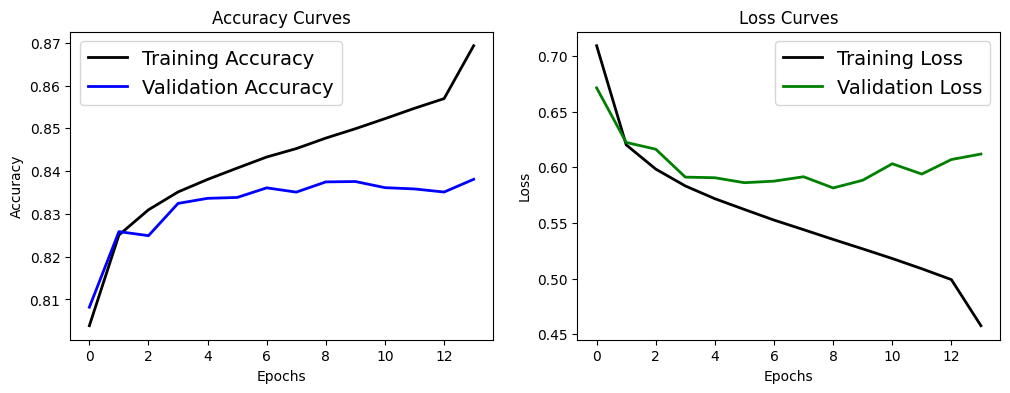

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_resnet.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_resnet.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_resnet.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_resnet.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Pretrained Model

## 1. VGG16

### Transfer learning을 이용해보기 - weight:ImageNet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import time
import seaborn as sns
import psutil
import cv2

from sklearn.model_selection import train_test_split

from collections import Counter

import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import tensorflow as tf
import pandas as pd
# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)   

Physical devices cannot be modified after being initialized


In [ ]:
X_train=np.load("X_byclass_train.npy")
X_test=np.load("X_byclass_test.npy")
y_train=np.load("y_byclass_train.npy")
y_test=np.load("y_byclass_test.npy")

In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
X_train.shape

(552000, 28, 28, 1)

In [ ]:
y_train.shape

(552000, 62)

In [ ]:
#데이터 전처리
import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.transform import resize

X_train_resized = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float32)
X_test_resized = np.zeros((X_test.shape[0], 32, 32, 3), dtype=np.float32)
X_val_resized = np.zeros((X_val.shape[0], 32, 32, 3), dtype=np.float32)

for i in range(X_train_resized.shape[0]):
    resized_image = resize(X_train[i], (32, 32), anti_aliasing=True)
    X_train_resized[i] = np.repeat(resized_image, 1, axis=-1)

for i in range(X_test_resized.shape[0]):
    resized_image = resize(X_test[i], (32, 32), anti_aliasing=True)
    X_test_resized[i] = np.repeat(resized_image, 1, axis=-1)

for i in range(X_val_resized.shape[0]):
    resized_image = resize(X_val[i], (32, 32), anti_aliasing=True)
    X_val_resized[i] = np.repeat(resized_image, 1, axis=-1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import layers, models

# VGG16 모델 불러오기
pre_trained_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# 마지막 dense 층 추가

flatten_layer = layers.Flatten()(pre_trained_model_VGG16.output)
prediction_layer = layers.Dense(62, activation='softmax')(flatten_layer)

model_VGG16 = Model(inputs=pre_trained_model_VGG16.input, outputs=prediction_layer)
model_VGG16.summary()

#아담 옵티마이저
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_VGG16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [ ]:
for layer in model_VGG16.layers[:-6]:
    layer.trainable = False
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.7587
Epoch 1: val_accuracy improved from -inf to 0.81199, saving model to Best_points.h5
4313/4313 [==============================] - 59s 12ms/step - loss: 0.9006 - accuracy: 0.7587 - val_loss: 0.6740 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 2/50
4313/4313 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.8205
Epoch 2: val_accuracy improved from 0.81199 to 0.82070, saving model to Best_points.h5
4313/4313 [==============================] - 50s 12ms/step - loss: 0.6489 - accuracy: 0.8205 - val_loss: 0.6555 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 3/50
4310/4313 [============================>.] - ETA: 0s - loss: 0.6256 - accuracy: 0.8262
Epoch 3: val_accuracy improved from 0.82070 to 0.82166, saving model to Best_points.h5
4313/4313 [==============================] - 50s 12ms/step - loss: 0.6256 - accuracy: 0.8262 - val_loss: 0.6332 - val_accuracy: 0.8217 - lr: 0.0010
Epoc

In [ ]:
model_VGG16.save('vgg_weight.h5')

In [ ]:
model_VGG16 = keras.models.load_model('vgg_weight.h5')

In [ ]:
for layer in model_VGG16.layers[:-14]:
    layer.trainable = False
    print(layer)

In [ ]:
for layer in model_VGG16.layers[-14:]:
    layer.trainable = True
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.8419
Epoch 1: val_accuracy improved from 0.83342 to 0.83540, saving model to Best_points.h5
4313/4313 [==============================] - 26s 6ms/step - loss: 0.5620 - accuracy: 0.8419 - val_loss: 0.5954 - val_accuracy: 0.8354 - lr: 2.0000e-04
Epoch 2/50
4310/4313 [============================>.] - ETA: 0s - loss: 0.5553 - accuracy: 0.8430
Epoch 2: val_accuracy improved from 0.83540 to 0.83600, saving model to Best_points.h5
4313/4313 [==============================] - 25s 6ms/step - loss: 0.5553 - accuracy: 0.8430 - val_loss: 0.5937 - val_accuracy: 0.8360 - lr: 2.0000e-04
Epoch 3/50
4311/4313 [============================>.] - ETA: 0s - loss: 0.5517 - accuracy: 0.8437
Epoch 3: val_accuracy did not improve from 0.83600
4313/4313 [==============================] - 25s 6ms/step - loss: 0.5517 - accuracy: 0.8437 - val_loss: 0.5951 - val_accuracy: 0.8357 - lr: 2.0000e-04
Epoch 4/50
4310/4313 [======

In [ ]:
model_VGG16.save('vgg_weight.h5')

In [ ]:
model_VGG16 = keras.models.load_model('vgg_weight.h5')

In [ ]:
for layer in model_VGG16.layers[:-14]:
    layer.trainable = True
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8468
Epoch 1: val_accuracy improved from -inf to 0.83757, saving model to Best_points.h5
4313/4313 [==============================] - 57s 12ms/step - loss: 0.5421 - accuracy: 0.8468 - val_loss: 0.5955 - val_accuracy: 0.8376 - lr: 1.0000e-04
Epoch 2/50
4313/4313 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.8497
Epoch 2: val_accuracy improved from 0.83757 to 0.83783, saving model to Best_points.h5
4313/4313 [==============================] - 49s 11ms/step - loss: 0.5296 - accuracy: 0.8497 - val_loss: 0.6155 - val_accuracy: 0.8378 - lr: 1.0000e-04
Epoch 3/50
4308/4313 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.8521
Epoch 3: val_accuracy improved from 0.83783 to 0.83787, saving model to Best_points.h5
4313/4313 [==============================] - 49s 11ms/step - loss: 0.5231 - accuracy: 0.8521 - val_loss: 0.6108 - val_accuracy: 0.8379 - lr: 1.0

Text(0.5, 1.0, 'Loss Curves')

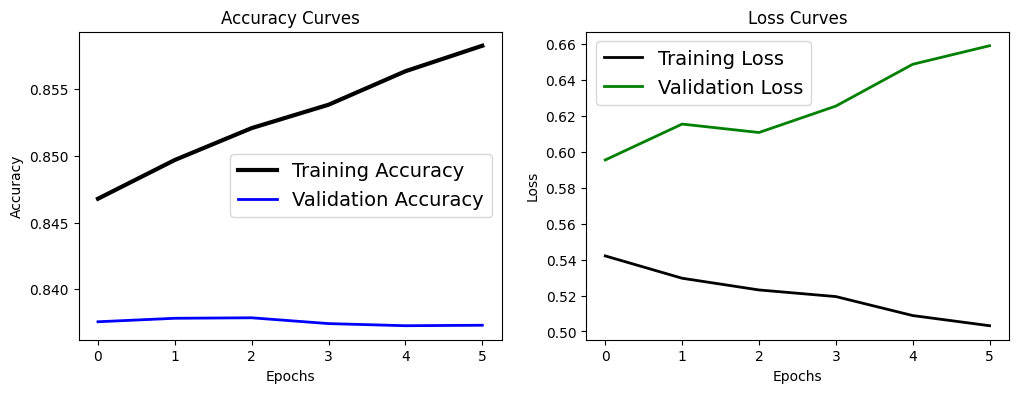

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_VGG16.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history_VGG16.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_VGG16.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_VGG16.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
start = time.time()
print(model_VGG16.evaluate(X_test_resized,y_test))

vgg16_test_time = time.time()-start
print("inference time : ", vgg16_test_time, "s")

2730/2730 [==============================] - 7s 2ms/step - loss: 0.6268 - accuracy: 0.8397
[0.6267653703689575, 0.839667558670044]
inference time :  8.054489612579346 s


In [ ]:
inference_byclass = pd.read_csv('my_emnist_gu.csv', header=None)
inference_byclass1 = pd.read_csv('my_emnist _lss(2).csv', header=None)
inference_byclass2 = pd.read_csv('sjw_hand (1).csv', header=None)
inference_byclass3 = pd.read_csv('my_emnist_ssh.csv', header=None)

inference_byclass = pd.concat([inference_byclass, inference_byclass1,inference_byclass2,inference_byclass3], axis=0)

In [ ]:
s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+l_alph+s_alph)
print(byclass_classes)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
# data label 나누기
X_inference = inference_byclass.iloc[:, 1:].to_numpy()
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])

In [ ]:
X_test = ((X_inference)).reshape(-1, 28, 28, 1).astype(float)
X_test_hand[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [ ]:
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])
y_test_hand = pd.get_dummies(inference_labels).to_numpy()

from skimage.transform import resize
X_test_hand = np.zeros((X_test.shape[0], 32, 32, 3), dtype=np.float32)

for i in range(X_test.shape[0]):
    resized_image = resize(X_test[i], (32, 32), anti_aliasing=True)
    X_test_hand[i] = np.repeat(resized_image, 1, axis=-1)

In [ ]:
X_test_hand=X_test_hand/255

In [ ]:
X_test_hand.shape

(2480, 32, 32, 3)

In [ ]:
print(model_VGG16.evaluate(X_test_hand,y_test_hand))

78/78 [==============================] - 0s 4ms/step - loss: 1.0497 - accuracy: 0.7020
[1.0496779680252075, 0.7020161151885986]


### Transfer learning - layer block3까지 잘라서

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import layers, models

# VGG16 모델 불러오기
pre_trained_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

for i in range(11):
    base_model_VGG16 = pre_trained_model_VGG16.layers[i]

# 마지막 dense 층 추가
flatten_layer = layers.Flatten()(base_model_VGG16.output)
prediction_layer = layers.Dense(62, activation='softmax')(flatten_layer)


model_VGG16 = Model(inputs=pre_trained_model_VGG16.input, outputs=prediction_layer)
model_VGG16.summary()

model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [ ]:
for layer in model_VGG16.layers[:-3]:
    layer.trainable = False
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4311/4313 [============================>.] - ETA: 0s - loss: 0.7736 - accuracy: 0.7992
Epoch 1: val_accuracy improved from -inf to 0.82395, saving model to Best_points.h5
4313/4313 [==============================] - 34s 8ms/step - loss: 0.7735 - accuracy: 0.7992 - val_loss: 0.6439 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 2/50
4308/4313 [============================>.] - ETA: 0s - loss: 0.6205 - accuracy: 0.8277
Epoch 2: val_accuracy improved from 0.82395 to 0.83070, saving model to Best_points.h5
4313/4313 [==============================] - 33s 8ms/step - loss: 0.6205 - accuracy: 0.8277 - val_loss: 0.6150 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 3/50
4307/4313 [============================>.] - ETA: 0s - loss: 0.5960 - accuracy: 0.8328
Epoch 3: val_accuracy improved from 0.83070 to 0.83141, saving model to Best_points.h5
4313/4313 [==============================] - 32s 8ms/step - loss: 0.5960 - accuracy: 0.8328 - val_loss: 0.6010 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 4

In [ ]:
for layer in model_VGG16.layers[:-3]:
    layer.trainable = True
    print(layer)

In [ ]:
for layer in model_VGG16.layers[:-9]:
    layer.trainable = False
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8497
Epoch 1: val_accuracy improved from -inf to 0.83838, saving model to Best_points.h5
4313/4313 [==============================] - 21s 3ms/step - loss: 0.5308 - accuracy: 0.8497 - val_loss: 0.5821 - val_accuracy: 0.8384 - lr: 2.0000e-04
Epoch 2/50
4305/4313 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.8514
Epoch 2: val_accuracy improved from 0.83838 to 0.83864, saving model to Best_points.h5
4313/4313 [==============================] - 14s 3ms/step - loss: 0.5257 - accuracy: 0.8514 - val_loss: 0.5818 - val_accuracy: 0.8386 - lr: 2.0000e-04
Epoch 3/50
4300/4313 [============================>.] - ETA: 0s - loss: 0.5230 - accuracy: 0.8522
Epoch 3: val_accuracy did not improve from 0.83864
4313/4313 [==============================] - 14s 3ms/step - loss: 0.5229 - accuracy: 0.8522 - val_loss: 0.5819 - val_accuracy: 0.8386 - lr: 2.0000e-04
Epoch 4/50
4307/4313 [=========

In [ ]:
model_VGG16.save('vgg_weight.h5')

In [ ]:
model_VGG16 = keras.models.load_model('vgg_weight.h5')

In [ ]:
for layer in model_VGG16.layers[:-9]:
    layer.trainable = True
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.8552
Epoch 1: val_accuracy improved from 0.83892 to 0.83941, saving model to Best_points.h5
4313/4313 [==============================] - 41s 9ms/step - loss: 0.5103 - accuracy: 0.8552 - val_loss: 0.5867 - val_accuracy: 0.8394 - lr: 1.0000e-04
Epoch 2/50
4313/4313 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8588
Epoch 2: val_accuracy did not improve from 0.83941
4313/4313 [==============================] - 31s 7ms/step - loss: 0.4971 - accuracy: 0.8588 - val_loss: 0.5906 - val_accuracy: 0.8392 - lr: 1.0000e-04
Epoch 3/50
4313/4313 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.8615
Epoch 3: val_accuracy did not improve from 0.83941
4313/4313 [==============================] - 31s 7ms/step - loss: 0.4869 - accuracy: 0.8615 - val_loss: 0.5979 - val_accuracy: 0.8383 - lr: 1.0000e-04
Epoch 4/50
4307/4313 [============================>.] - ETA: 0s 

Text(0.5, 1.0, 'Loss Curves')

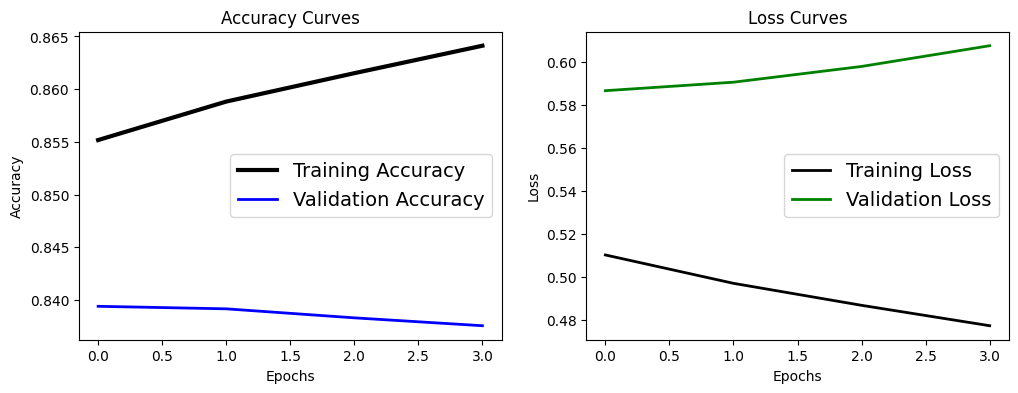

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_VGG16.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history_VGG16.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_VGG16.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_VGG16.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
start = time.time()
print(model_VGG16.evaluate(X_test_resized,y_test))

vgg16_test_time = time.time()-start
print("inference time : ", vgg16_test_time, "s")

2730/2730 [==============================] - 5s 2ms/step - loss: 0.5796 - accuracy: 0.8408
[0.5795542597770691, 0.8407664895057678]
inference time :  6.385617256164551 s


### image를 zero padding 후 넣어서

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ZeroPadding2D, Input, BatchNormalization, Dropout

input_layer = Input(shape=(28, 28, 1))
padded_layer = ZeroPadding2D(padding=((50, 50), (50, 50)))(input_layer)
layer = tf.keras.layers.Concatenate()([padded_layer, padded_layer, padded_layer])

# VGG16 모델 불러오기
pre_trained_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for i in range(11):
    base_model_VGG16 = pre_trained_model_VGG16.layers[i]
    layer = base_model_VGG16(layer)

# 마지막 dense 층 추가
final_model = BatchNormalization()(layer)
final_model = Flatten()(final_model)
final_model = Dropout(0.5)(final_model)
prediction_layer = Dense(62, activation='softmax')(final_model)


model_VGG16 = Model(inputs=input_layer, outputs=prediction_layer)
model_VGG16.summary()

model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 128, 128, 1)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 3)  0           ['zero_padding2d_1[0][0]',       
                                                                  'zero_padding2d_1[0][0]',       
                                                                  'zero_padding2d_1[0][0]'] 

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
MCP = ModelCheckpoint('Best_points_vgg.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [ ]:
for layer in model_VGG16.layers[:-6]:
    layer.trainable = False
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val),callbacks=[MCP,ES])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.8921 - accuracy: 0.7777
Epoch 1: val_accuracy improved from -inf to 0.82407, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 366s 85ms/step - loss: 0.8921 - accuracy: 0.7777 - val_loss: 0.6773 - val_accuracy: 0.8241
Epoch 2/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.8198
Epoch 2: val_accuracy improved from 0.82407 to 0.83017, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 362s 84ms/step - loss: 0.6647 - accuracy: 0.8198 - val_loss: 0.6183 - val_accuracy: 0.8302
Epoch 3/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.6258 - accuracy: 0.8275
Epoch 3: val_accuracy improved from 0.83017 to 0.83409, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 360s 84ms/step - loss: 0.6258 - accuracy: 0.8275 - val_loss: 0.6005 - val_accuracy: 0.8341
Epoch 4/50
4312/4313 [======

In [ ]:
for layer in model_VGG16.layers:
    layer.trainable = True
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_val,y_val),callbacks=[MCP,ES])

Epoch 1/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.5723 - accuracy: 0.8411
Epoch 1: val_accuracy improved from 0.83970 to 0.84055, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 353s 82ms/step - loss: 0.5723 - accuracy: 0.8411 - val_loss: 0.5735 - val_accuracy: 0.8406
Epoch 2/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.8421
Epoch 2: val_accuracy improved from 0.84055 to 0.84099, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 354s 82ms/step - loss: 0.5650 - accuracy: 0.8421 - val_loss: 0.5838 - val_accuracy: 0.8410
Epoch 3/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.5599 - accuracy: 0.8437
Epoch 3: val_accuracy improved from 0.84099 to 0.84100, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 354s 82ms/step - loss: 0.5599 - accuracy: 0.8437 - val_loss: 0.5773 - val_accuracy: 0.8410
Epoch 4/50
4312/4313 [===

Text(0.5, 1.0, 'Loss Curves')

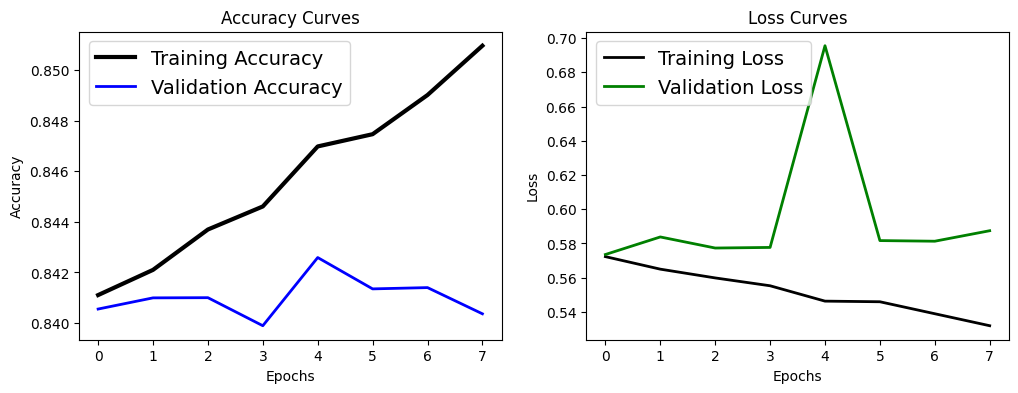

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_VGG16.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history_VGG16.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_VGG16.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_VGG16.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
start = time.time()
print(model_VGG16.evaluate(X_test,y_test))

vgg16_test_time = time.time()-start
print("inference time : ", vgg16_test_time, "s")

2730/2730 [==============================] - 17s 6ms/step - loss: 0.5736 - accuracy: 0.8439
[0.5736124515533447, 0.8438802361488342]
inference time :  18.197486639022827 s


### 동일한 model을 resized data를 통해서(128은 memory때문에 불가능, (32,32,3)사용

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout


# VGG16 모델 불러오기
pre_trained_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

for i in range(11):
    base_model_VGG16 = pre_trained_model_VGG16.layers[i]

# 마지막 dense 층 추가
final_model = BatchNormalization()(base_model_VGG16.output)
final_model = Flatten()(final_model)
final_model = Dropout(0.5)(final_model)
prediction_layer = Dense(62, activation='softmax')(final_model)


model_VGG16 = Model(inputs=pre_trained_model_VGG16.input, outputs=prediction_layer)
model_VGG16.summary()

model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
MCP = ModelCheckpoint('Best_points_vgg.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [ ]:
for layer in model_VGG16.layers[:-4]:
    layer.trainable = False
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.7616 - accuracy: 0.7996
Epoch 1: val_accuracy improved from -inf to 0.82659, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 39s 8ms/step - loss: 0.7616 - accuracy: 0.7996 - val_loss: 0.6314 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 2/50
4308/4313 [============================>.] - ETA: 0s - loss: 0.6320 - accuracy: 0.8263
Epoch 2: val_accuracy improved from 0.82659 to 0.83222, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 32s 7ms/step - loss: 0.6320 - accuracy: 0.8263 - val_loss: 0.6038 - val_accuracy: 0.8322 - lr: 0.0010
Epoch 3/50
4307/4313 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.8319
Epoch 3: val_accuracy improved from 0.83222 to 0.83580, saving model to Best_points_vgg.h5
4313/4313 [==============================] - 32s 7ms/step - loss: 0.6060 - accuracy: 0.8320 - val_loss: 0.5917 - val_accuracy: 0.8358 - lr: 0.

In [ ]:
for layer in model_VGG16.layers:
    layer.trainable = True
    print(layer)

In [ ]:
history_VGG16 = model_VGG16.fit(X_train_resized,y_train,batch_size=128,epochs=50,validation_data=(X_val_resized,y_val),callbacks=[MCP,ES,RLP])

Epoch 1/50
4306/4313 [============================>.] - ETA: 0s - loss: 0.4689 - accuracy: 0.8672
Epoch 1: val_accuracy did not improve from 0.84320
4313/4313 [==============================] - 41s 10ms/step - loss: 0.4688 - accuracy: 0.8672 - val_loss: 0.5918 - val_accuracy: 0.8423 - lr: 1.0000e-04
Epoch 2/50
4307/4313 [============================>.] - ETA: 0s - loss: 0.4616 - accuracy: 0.8689
Epoch 2: val_accuracy did not improve from 0.84320
4313/4313 [==============================] - 31s 7ms/step - loss: 0.4616 - accuracy: 0.8689 - val_loss: 0.5986 - val_accuracy: 0.8422 - lr: 1.0000e-04
Epoch 3/50
4313/4313 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.8707
Epoch 3: val_accuracy did not improve from 0.84320
4313/4313 [==============================] - 31s 7ms/step - loss: 0.4543 - accuracy: 0.8707 - val_loss: 0.6082 - val_accuracy: 0.8412 - lr: 1.0000e-04
Epoch 4/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8725
E

Text(0.5, 1.0, 'Loss Curves')

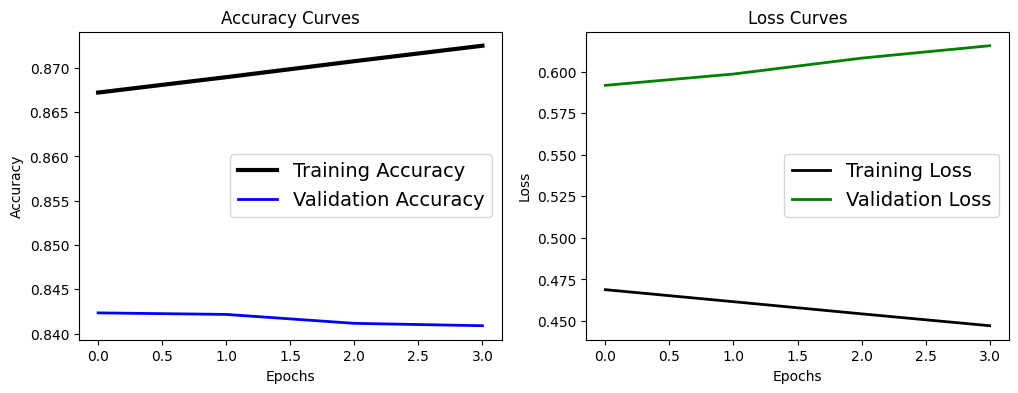

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_VGG16.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history_VGG16.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_VGG16.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_VGG16.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
start = time.time()
print(model_VGG16.evaluate(X_test_resized,y_test))

vgg16_test_time = time.time()-start
print("inference time : ", vgg16_test_time, "s")

2730/2730 [==============================] - 5s 2ms/step - loss: 0.5865 - accuracy: 0.8448
[0.5865110158920288, 0.8447502255439758]
inference time :  6.311244487762451 s


In [ ]:
inference_byclass = pd.read_csv('my_emnist_gu.csv', header=None)
inference_byclass1 = pd.read_csv('my_emnist _lss(2).csv', header=None)
inference_byclass2 = pd.read_csv('sjw_hand (1).csv', header=None)
inference_byclass3 = pd.read_csv('my_emnist_ssh.csv', header=None)

inference_byclass = pd.concat([inference_byclass, inference_byclass1,inference_byclass2,inference_byclass3], axis=0)

In [ ]:
s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+l_alph+s_alph)
print(byclass_classes)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
# data label 나누기
X_inference = inference_byclass.iloc[:, 1:].to_numpy()
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])

In [ ]:
X_test = ((X_inference)).reshape(-1, 28, 28, 1).astype(float)

In [ ]:
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])
y_test_hand = pd.get_dummies(inference_labels).to_numpy()

from skimage.transform import resize
X_test_hand = np.zeros((X_test.shape[0], 32, 32, 3), dtype=np.float32)

for i in range(X_test.shape[0]):
    resized_image = resize(X_test[i], (32, 32), anti_aliasing=True)
    X_test_hand[i] = np.repeat(resized_image, 1, axis=-1)

In [ ]:
X_test_hand=X_test_hand/255

In [ ]:
print(model_VGG16.evaluate(X_test_hand,y_test_hand))

78/78 [==============================] - 0s 3ms/step - loss: 0.9196 - accuracy: 0.7383
[0.9196152091026306, 0.73830646276474]


## 2. MobilenetV2

### 단계별 학습- 모든 레이어 freeze한 후에 higher layer부터 단계별로 풀어가며 학습
[150,154] 3epoch , [141,154] 3 epoch ,[134,154] 4 epoch, [100,154] 4epoch

In [ ]:
X_train=np.load("X_byclass_train.npy")
X_test=np.load("X_byclass_test.npy")
y_train=np.load("y_byclass_train.npy")
y_test=np.load("y_byclass_test.npy")

In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

32X32,3 reshape 진행

In [ ]:
#데이터 전처리

import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils



from skimage.transform import resize

from skimage.transform import resize

#zero 함수로 32,32,3으로 형태 만듬 
X_train_resized = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float32)
X_test_resized = np.zeros((X_test.shape[0], 32, 32, 3), dtype=np.float32)
X_val_resized = np.zeros((X_val.shape[0], 32, 32, 3), dtype=np.float32)

#값들 조정
for i in range(X_train_resized.shape[0]):
    resized_image = resize(X_train[i], (32, 32), anti_aliasing=True)
    X_train_resized[i] = np.repeat(resized_image, 1, axis=-1)

for i in range(X_test_resized.shape[0]):
    resized_image = resize(X_test[i], (32, 32), anti_aliasing=True)
    X_test_resized[i] = np.repeat(resized_image, 1, axis=-1)

for i in range(X_val_resized.shape[0]):
    resized_image = resize(X_val[i], (32, 32), anti_aliasing=True)
    X_val_resized[i] = np.repeat(resized_image, 1, axis=-1)
    
    

In [ ]:
X_val_resized.shape 

(138000, 32, 32, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32, 32, 3),weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

output = tf.keras.layers.Dense(62, activation="softmax")(avg) # 클래스 수에 따라 수정


#아담 옵티마이저
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)


model_MobileNetV2 = Model(inputs=base_model.input, outputs=output)
# 모델 컴파일
#loss function categorical_crossentropy
model_MobileNetV2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

model_MobileNetV2.summary()


ES = EarlyStopping(monitor='val_loss', patience=5)
CB = keras.callbacks.ModelCheckpoint('model_MobileNetV2.h5', save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132),range(132,154)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_2                33: block_3_depthwise_relu 66: block_7_depthwise      99: block_11_expand_BN    132: block_14_project_BN   
  1: Conv1                  34: block_3_project        67: block_7_depthwise_BN  100: block_11_expand_relu  133: block_14_add          
  2: bn_Conv1               35: block_3_project_BN     68: block_7_depthwise_relu101: block_11_depthwise    134: block_15_expand       
  3: Conv1_relu             36: block_4_expand         69: block_7_project       102: block_11_depthwise_BN 135: block_15_expand_BN    
  4: expanded_conv_depthwise 37: block_4_expand_BN      70: block_7_project_BN    103: block_11_depthwise_relu136: block_15_expand_relu  
  5: expanded_conv_depthwise_BN 38: block_4_expand_relu    71: block_7_add           104: block_11_project      137: block_15_depthwise    
  6: expanded_conv_depthwise_relu 39: block_4_depthwise      72: block_8_expand        105: block_11_project_BN   138: block_15_depthwise_BN 
  7: expanded_conv_project  40: bloc

#여기서부터 단계별 학습

In [ ]:
for layer in model_MobileNetV2.layers:
    layer.trainable = False

In [ ]:
for layer in model_MobileNetV2.layers[-4:]:
    layer.trainable = True

In [ ]:
n_epochs = 3
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/3
4313/4313 [==============================] - 77s 17ms/step - loss: 0.8110 - accuracy: 0.7803 - val_loss: 1.0565 - val_accuracy: 0.7538 - lr: 0.0010
Epoch 2/3
4313/4313 [==============================] - 74s 17ms/step - loss: 0.7319 - accuracy: 0.7961 - val_loss: 3.4221 - val_accuracy: 0.4386 - lr: 0.0010
Epoch 3/3
4313/4313 [==============================] - 74s 17ms/step - loss: 0.6699 - accuracy: 0.8117 - val_loss: 0.9581 - val_accuracy: 0.7687 - lr: 0.0010


In [ ]:
model_MobileNetV2.save_weights('mobile_weights.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights.h5')

In [ ]:
for layer in model_MobileNetV2.layers[141:]:
    layer.trainable = True

In [ ]:
n_epochs = 3
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/3
4313/4313 [==============================] - 75s 17ms/step - loss: 0.6438 - accuracy: 0.8185 - val_loss: 0.6709 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 2/3
4313/4313 [==============================] - 73s 17ms/step - loss: 0.6699 - accuracy: 0.8126 - val_loss: 0.7646 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 3/3
4313/4313 [==============================] - 74s 17ms/step - loss: 0.6258 - accuracy: 0.8234 - val_loss: 0.6562 - val_accuracy: 0.8182 - lr: 0.0010


In [ ]:
model_MobileNetV2.save_weights('mobile_weights.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights.h5')

In [ ]:
for layer in model_MobileNetV2.layers[134:]:
    layer.trainable = True

In [ ]:
n_epochs = 4
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/4
4313/4313 [==============================] - 87s 18ms/step - loss: 0.6215 - accuracy: 0.8251 - val_loss: 0.9371 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 2/4
4313/4313 [==============================] - 74s 17ms/step - loss: 0.6057 - accuracy: 0.8288 - val_loss: 0.6446 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 3/4
4313/4313 [==============================] - 73s 17ms/step - loss: 0.5999 - accuracy: 0.8306 - val_loss: 0.6613 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 4/4
4313/4313 [==============================] - 73s 17ms/step - loss: 0.6254 - accuracy: 0.8256 - val_loss: 0.6369 - val_accuracy: 0.8204 - lr: 0.0010


In [ ]:
model_MobileNetV2.save_weights('mobile_weights.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights.h5')

In [ ]:
for layer in model_MobileNetV2.layers[100:]:
    layer.trainable = True

In [ ]:
n_epochs = 4
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/4
4313/4313 [==============================] - 84s 17ms/step - loss: 0.5916 - accuracy: 0.8325 - val_loss: 0.6102 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 2/4
4313/4313 [==============================] - 76s 18ms/step - loss: 0.5966 - accuracy: 0.8314 - val_loss: 0.7683 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 3/4
4313/4313 [==============================] - 73s 17ms/step - loss: 0.5890 - accuracy: 0.8329 - val_loss: 0.6037 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 4/4
4313/4313 [==============================] - 73s 17ms/step - loss: 0.5816 - accuracy: 0.8348 - val_loss: 0.6073 - val_accuracy: 0.8290 - lr: 0.0010


In [ ]:
model_MobileNetV2.save_weights('mobile_weights.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights.h5')

In [ ]:
for layer in model_MobileNetV2.layers:
    layer.trainable = True

In [ ]:
n_epochs = 30
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/30
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5757 - accuracy: 0.8362 - val_loss: 0.6169 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 2/30
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5733 - accuracy: 0.8373 - val_loss: 0.6054 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 3/30
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5697 - accuracy: 0.8381 - val_loss: 0.6461 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 4/30
4313/4313 [==============================] - 74s 17ms/step - loss: 0.6137 - accuracy: 0.8296 - val_loss: 0.6181 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 5/30
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5785 - accuracy: 0.8361 - val_loss: 0.6104 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 6/30
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5698 - accuracy: 0.8385 - val_loss: 0.5999 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 7/30
4313/4313 [========================

Text(0.5, 1.0, 'Loss Curves')

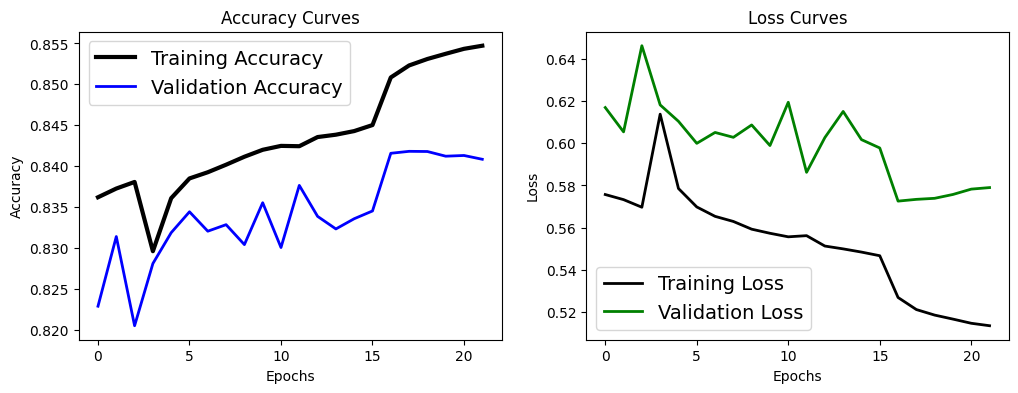

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], 'black', linewidth=2.0)
ax2.plot(history.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
start = time.time()
print(model_MobileNetV2.evaluate(X_test_resized,y_test))

LeNet_test_time = time.time()-start
print("inference time : ",  time.time()-start, "s")

2762/2762 [==============================] - 18s 6ms/step - loss: 0.5784 - accuracy: 0.8415
[0.5784056186676025, 0.8415437340736389]
inference time :  19.419606685638428 s


### 단계별 학습-2 
freeze하는 영역을 다르게 하여 학습
 [150,154]  10 epoch, [134,154] 5 epoch, [116,154]  5epoch


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32, 32, 3),weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

output = tf.keras.layers.Dense(62, activation="softmax")(avg) # 클래스 수에 따라 수정


#아담 옵티마이저
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)


model_MobileNetV2 = Model(inputs=base_model.input, outputs=output)
# 모델 컴파일
#loss function categorical_crossentropy
model_MobileNetV2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


ES = EarlyStopping(monitor='val_loss', patience=5)
CB = keras.callbacks.ModelCheckpoint('model_MobileNetV2.h5', save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

In [ ]:
for layer in model_MobileNetV2.layers:
    layer.trainable = False

In [ ]:
for layer in model_MobileNetV2.layers[-4:]:
    layer.trainable = True

In [ ]:
n_epochs = 10
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP ])

Epoch 1/10
4313/4313 [==============================] - 84s 19ms/step - loss: 0.7879 - accuracy: 0.7852 - val_loss: 0.8763 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 2/10
4313/4313 [==============================] - 79s 18ms/step - loss: 0.7099 - accuracy: 0.8032 - val_loss: 0.7341 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 3/10
4313/4313 [==============================] - 80s 19ms/step - loss: 0.7089 - accuracy: 0.8025 - val_loss: 0.7930 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 4/10
4313/4313 [==============================] - 78s 18ms/step - loss: 0.6793 - accuracy: 0.8094 - val_loss: 0.7698 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 5/10
4313/4313 [==============================] - 80s 18ms/step - loss: 0.6331 - accuracy: 0.8205 - val_loss: 0.6515 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 6/10
4313/4313 [==============================] - 79s 18ms/step - loss: 0.6193 - accuracy: 0.8248 - val_loss: 0.6732 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 7/10
4313/4313 [========================

In [ ]:
model_MobileNetV2.save_weights('mobile_weights1.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights1.h5')

In [ ]:
for layer in model_MobileNetV2.layers[134:]:
    layer.trainable = True

In [ ]:
n_epochs = 5
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP ])

Epoch 1/5
4313/4313 [==============================] - 105s 22ms/step - loss: 0.6135 - accuracy: 0.8283 - val_loss: 0.6950 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 2/5
4313/4313 [==============================] - 91s 21ms/step - loss: 0.6442 - accuracy: 0.8205 - val_loss: 0.8509 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/5
4313/4313 [==============================] - 92s 21ms/step - loss: 0.6192 - accuracy: 0.8245 - val_loss: 0.7013 - val_accuracy: 0.8054 - lr: 0.0010
Epoch 4/5
4313/4313 [==============================] - 92s 21ms/step - loss: 0.6350 - accuracy: 0.8215 - val_loss: 0.8393 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 5/5
4313/4313 [==============================] - 93s 21ms/step - loss: 0.6292 - accuracy: 0.8219 - val_loss: 0.6540 - val_accuracy: 0.8179 - lr: 0.0010


In [ ]:
model_MobileNetV2.save_weights('mobile_weights1.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights1.h5')

In [ ]:
for layer in model_MobileNetV2.layers[116:]:
    layer.trainable = True

In [ ]:
n_epochs = 5
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP ])

Epoch 1/5
4313/4313 [==============================] - 93s 22ms/step - loss: 0.6283 - accuracy: 0.8221 - val_loss: 0.7033 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 2/5
4313/4313 [==============================] - 91s 21ms/step - loss: 0.6251 - accuracy: 0.8239 - val_loss: 0.6172 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 3/5
4313/4313 [==============================] - 92s 21ms/step - loss: 0.6172 - accuracy: 0.8262 - val_loss: 0.6654 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 4/5
4313/4313 [==============================] - 92s 21ms/step - loss: 0.6147 - accuracy: 0.8271 - val_loss: 0.6524 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 5/5
4313/4313 [==============================] - 92s 21ms/step - loss: 0.6252 - accuracy: 0.8234 - val_loss: 0.7969 - val_accuracy: 0.7782 - lr: 0.0010


In [ ]:
model_MobileNetV2.save_weights('mobile_weights1.h5')

In [ ]:
model_MobileNetV2.load_weights('mobile_weights1.h5')

In [ ]:
for layer in model_MobileNetV2.layers:
    layer.trainable = True

In [ ]:
n_epochs = 50
history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/50
4313/4313 [==============================] - 84s 17ms/step - loss: 0.6293 - accuracy: 0.8232 - val_loss: 0.7384 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 2/50
4313/4313 [==============================] - 73s 17ms/step - loss: 0.6246 - accuracy: 0.8242 - val_loss: 0.8422 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 3/50
4313/4313 [==============================] - 73s 17ms/step - loss: 0.6663 - accuracy: 0.8145 - val_loss: 0.6492 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 4/50
4313/4313 [==============================] - 74s 17ms/step - loss: 0.6000 - accuracy: 0.8291 - val_loss: 0.7827 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 5/50
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5866 - accuracy: 0.8329 - val_loss: 0.6327 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 6/50
4313/4313 [==============================] - 74s 17ms/step - loss: 0.5893 - accuracy: 0.8329 - val_loss: 0.6074 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 7/50
4313/4313 [========================

In [ ]:
start = time.time()
print(model_MobileNetV2.evaluate(X_test_resized,y_test))

MobileNet_test_time = time.time()-start
print("inference time : ",  time.time()-start, "s")

2762/2762 [==============================] - 17s 6ms/step - loss: 0.5728 - accuracy: 0.8408
[0.5728434324264526, 0.8407517075538635]
inference time :  17.864433765411377 s


Text(0.5, 1.0, 'Loss Curves')

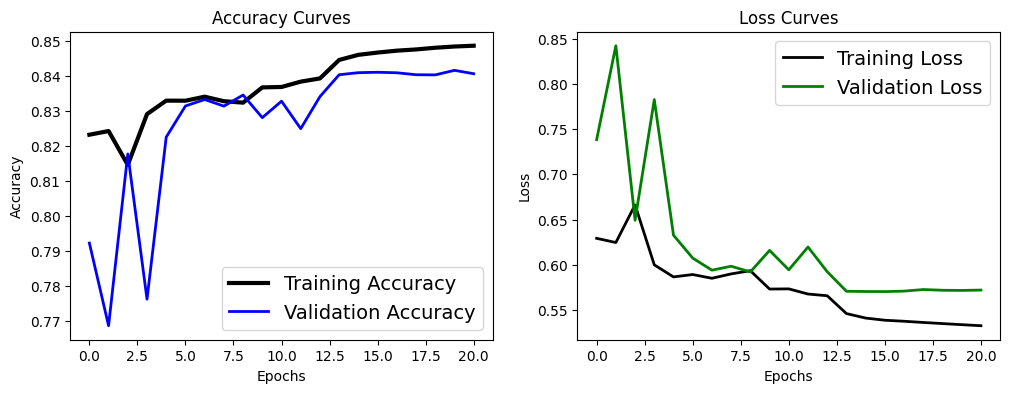

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], 'black', linewidth=2.0)
ax2.plot(history.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### all traininable 

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32, 32, 3),weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

output = tf.keras.layers.Dense(62, activation="softmax")(avg) # 클래스 수에 따라 수정


#아담 옵티마이저
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)


model_MobileNetV2 = Model(inputs=base_model.input, outputs=output)
# 모델 컴파일
#loss function categorical_crossentropy
model_MobileNetV2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


ES = EarlyStopping(monitor='val_loss', patience=5)
CB = keras.callbacks.ModelCheckpoint('model_MobileNetV2.h5', save_best_only=True)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

In [ ]:
for layer in model_MobileNetV2.layers:
    layer.trainable = True

In [ ]:

history=model_MobileNetV2.fit(X_train_resized,y_train,epochs=n_epochs, batch_size=128,verbose=1, validation_data=(X_val_resized,y_val),callbacks=[ES,CB,RLP])

Epoch 1/100
4313/4313 [==============================] - 72s 17ms/step - loss: 0.6746 - accuracy: 0.8116 - val_loss: 1.1341 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 2/100
4313/4313 [==============================] - 72s 17ms/step - loss: 0.6363 - accuracy: 0.8211 - val_loss: 0.8081 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 3/100
4313/4313 [==============================] - 72s 17ms/step - loss: 0.6224 - accuracy: 0.8248 - val_loss: 1.8579 - val_accuracy: 0.6430 - lr: 0.0010
Epoch 4/100
4313/4313 [==============================] - 73s 17ms/step - loss: 0.6093 - accuracy: 0.8282 - val_loss: 0.6743 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 5/100
4313/4313 [==============================] - 73s 17ms/step - loss: 0.6021 - accuracy: 0.8302 - val_loss: 0.6950 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 6/100
4313/4313 [==============================] - 73s 17ms/step - loss: 0.5967 - accuracy: 0.8315 - val_loss: 0.6252 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 7/100
4313/4313 [=================

In [ ]:
start = time.time()
print(model_MobileNetV2.evaluate(X_test_resized,y_test))

MobileNet_test_time = time.time()-start
print("inference time : ",  time.time()-start, "s")

2762/2762 [==============================] - 17s 6ms/step - loss: 0.5711 - accuracy: 0.8414
[0.5710918307304382, 0.8413739800453186]
inference time :  18.634480237960815 s


Text(0.5, 1.0, 'Loss Curves')

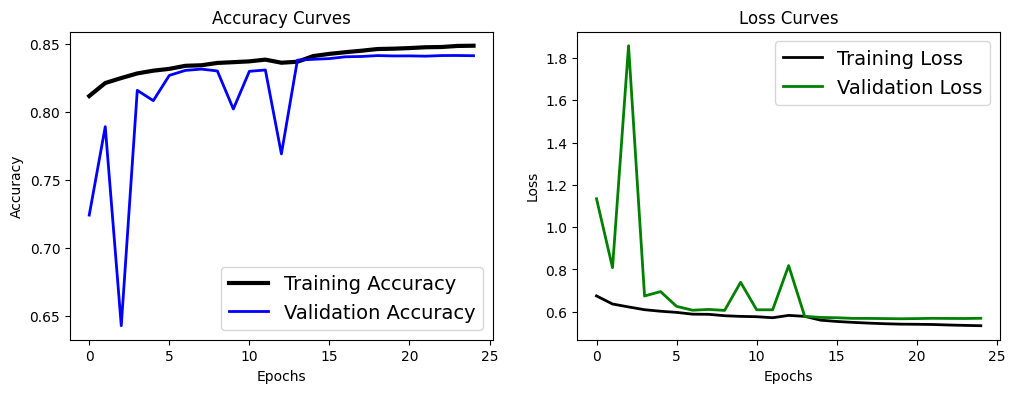

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], 'black', linewidth=3.0)
ax1.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], 'black', linewidth=2.0)
ax2.plot(history.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [51]:
import pandas as pd
inference_byclass = pd.read_csv('my_emnist_gu (1).csv', header=None)
inference_byclass1 = pd.read_csv('my_emnist _lss(2).csv', header=None)
inference_byclass2 = pd.read_csv('sjw_hand (1).csv', header=None)
inference_byclass3 = pd.read_csv('my_emnist_ssh.csv', header=None)
inference_byclass = pd.concat([inference_byclass, inference_byclass1,inference_byclass2,inference_byclass3], axis=0)

In [52]:
import string
import numpy as np
s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_classes=np.transpose(number+l_alph+s_alph)
print(byclass_classes) 

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [53]:
 # data label 나누기
X_inference = inference_byclass.iloc[:, 1:].to_numpy()
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])

In [54]:
X_test = ((X_inference)).reshape(-1, 28, 28, 1).astype(float)

In [55]:
inference_labels = np.transpose(byclass_classes[inference_byclass.iloc[:,0].tolist()])
y_test_hand = pd.get_dummies(inference_labels).to_numpy()

In [56]:
from skimage.transform import resize
X_test_hand = np.zeros((X_test.shape[0], 32, 32, 3), dtype=np.float32)

for i in range(X_test.shape[0]):
    resized_image = resize(X_test[i], (32, 32), anti_aliasing=True)
    X_test_hand[i] = np.repeat(resized_image, 1, axis=-1)


In [61]:
model_MobileNetV2= keras.models.load_model('final_mobile_weights1 (1).h5')

In [62]:
X_test_hand=X_test_hand/255

handmade_inference결과

In [63]:
#inference
print(model_MobileNetV2.evaluate(X_test_hand,y_test_hand))

78/78 [==============================] - 3s 31ms/step - loss: 0.9283 - accuracy: 0.7044
[0.9282863736152649, 0.7044354677200317]


## 3. InceptionV3

### 제일 첫 레이어만 오픈

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import time
import seaborn as sns
import psutil
import cv2

from sklearn.model_selection import train_test_split

from collections import Counter

import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import tensorflow as tf
import pandas as pd
# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)   

1 Physical GPUs, 1 Logical GPUs


In [ ]:
X_train=np.load("X_byclass_train.npy")
X_test=np.load("X_byclass_test.npy")
y_train=np.load("y_byclass_train.npy")
y_test=np.load("y_byclass_test.npy")

In [ ]:
#train val test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
X_train.shape

(552000, 28, 28, 1)

In [ ]:
y_train.shape

(552000, 62)

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense
from tensorflow.keras.layers import ReLU, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from PIL import Image 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

from itertools import product

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, ZeroPadding2D,Flatten, Dropout
from tensorflow.keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

input_layer = Input(shape=(28, 28, 1))
pad_layer = ZeroPadding2D(padding=((61, 61), (61, 61)))(input_layer)
layer = tf.keras.layers.Concatenate()([pad_layer, pad_layer, pad_layer])

for i in range(20):
    base_model_layer = base_model.layers[i]
    layer = base_model_layer(layer)

x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(layer)
x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(units=62, activation='softmax')(x)

model_inception = Model(inputs=input_layer, outputs=x)
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 150, 150, 1)  0          ['input_2[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 150, 150, 3)  0           ['zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]']         
                                                                                              

In [ ]:
for layer in model_inception.layers[:-9]:
    layer.trainable = False
    print(layer)

In [ ]:
keras.backend.clear_session()
model_inception.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model_inception_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

In [ ]:
start = time.time()
history_incep = model_inception.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
4309/4313 [============================>.] - ETA: 0s - loss: 0.9834 - accuracy: 0.7608
Epoch 1: val_loss improved from inf to 0.91781, saving model to ./model_inception_checkpoint\cp-01-0.9178.ckpt
4313/4313 [==============================] - 51s 12ms/step - loss: 0.9832 - accuracy: 0.7608 - val_loss: 0.9178 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 2/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.7639 - accuracy: 0.8022
Epoch 2: val_loss improved from 0.91781 to 0.81426, saving model to ./model_inception_checkpoint\cp-02-0.8143.ckpt
4313/4313 [==============================] - 50s 12ms/step - loss: 0.7639 - accuracy: 0.8022 - val_loss: 0.8143 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 3/50
4308/4313 [============================>.] - ETA: 0s - loss: 0.7288 - accuracy: 0.8094
Epoch 3: val_loss did not improve from 0.81426
4313/4313 [==============================] - 51s 12ms/step - loss: 0.7289 - accuracy: 0.8094 - val_loss: 0.8544 - val_accuracy: 0.7321 - 

In [ ]:
start = time.time()
print(model_inception.evaluate(X_test,y_test))

model_inception_test_time = time.time()-start
print("inference time : ", model_inception_test_time, "s")

2730/2730 [==============================] - 6s 2ms/step - loss: 0.5852 - accuracy: 0.8370
[0.5852354764938354, 0.8370346426963806]
inference time :  6.089142560958862 s


In [ ]:
model_inception.save("model_inceptionV5.h5")

Text(0.5, 1.0, 'Loss Curves')

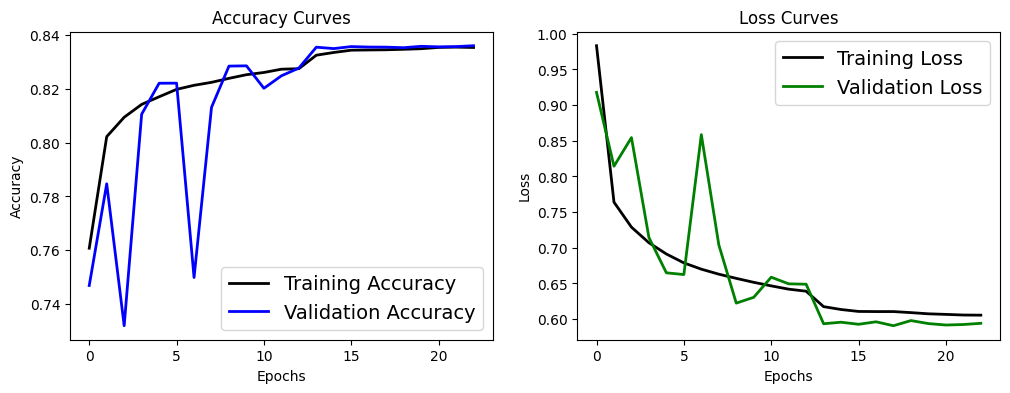

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_incep.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_incep.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_incep.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_incep.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### activation3 layer까지 오픈

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, ZeroPadding2D,Flatten, Dropout
from tensorflow.keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

input_layer = Input(shape=(28, 28, 1))
pad_layer = ZeroPadding2D(padding=((61, 61), (61, 61)))(input_layer)
layer = tf.keras.layers.Concatenate()([pad_layer, pad_layer, pad_layer])

for i in range(20):
    base_model_layer = base_model.layers[i]
    layer = base_model_layer(layer)

x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(layer)
x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(units=62, activation='softmax')(x)

model_inception = Model(inputs=input_layer, outputs=x)
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 150, 150, 1)  0          ['input_2[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 150, 150, 3)  0           ['zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]']         
                                                                                              

In [ ]:
for layer in model_inception.layers[:-14]:
    layer.trainable = False
    print(layer)

In [ ]:
keras.backend.clear_session()
model_inception.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model_inception_1_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

In [ ]:
start = time.time()
history_incep_1 = model_inception.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.8783 - accuracy: 0.7825
Epoch 1: val_loss improved from inf to 5.54678, saving model to ./model_inception_1_checkpoint\cp-01-5.5468.ckpt
4313/4313 [==============================] - 71s 16ms/step - loss: 0.8783 - accuracy: 0.7825 - val_loss: 5.5468 - val_accuracy: 0.1417 - lr: 0.0010
Epoch 2/50
4310/4313 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.8181
Epoch 2: val_loss did not improve from 5.54678
4313/4313 [==============================] - 70s 16ms/step - loss: 0.6875 - accuracy: 0.8181 - val_loss: 9.8352 - val_accuracy: 0.1109 - lr: 0.0010
Epoch 3/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.8240
Epoch 3: val_loss improved from 5.54678 to 0.80346, saving model to ./model_inception_1_checkpoint\cp-03-0.8035.ckpt
4313/4313 [==============================] - 71s 16ms/step - loss: 0.6576 - accuracy: 0.8240 - val_loss: 0.8035 - val_accuracy: 0.800

In [ ]:
start = time.time()
print(model_inception.evaluate(X_test,y_test))

model_inception_test_time = time.time()-start
print("inference time : ", model_inception_test_time, "s")

2730/2730 [==============================] - 6s 2ms/step - loss: 0.5726 - accuracy: 0.8422
[0.5726076364517212, 0.8422203660011292]
inference time :  5.96461820602417 s


In [ ]:
model_inception.save("model_inceptionV5_1.h5")

Text(0.5, 1.0, 'Loss Curves')

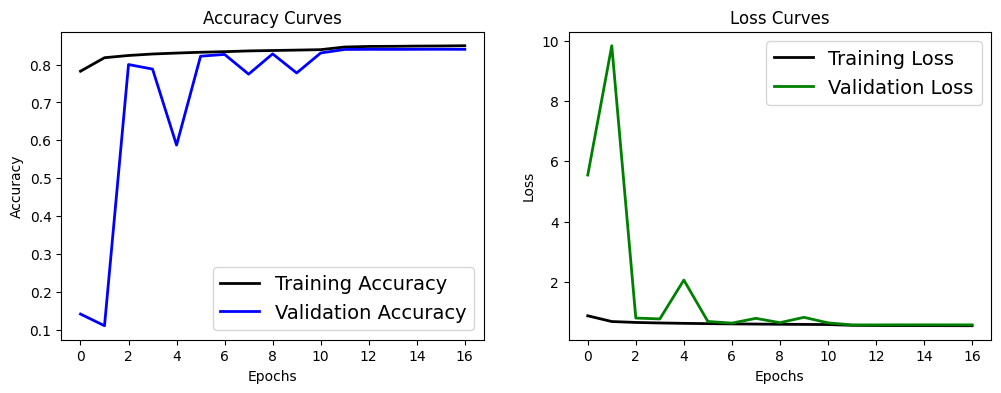

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_incep_1.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_incep_1.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_incep_1.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_incep_1.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### activation1까지 오픈

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, ZeroPadding2D,Flatten, Dropout
from tensorflow.keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

input_layer = Input(shape=(28, 28, 1))
pad_layer = ZeroPadding2D(padding=((61, 61), (61, 61)))(input_layer)
layer = tf.keras.layers.Concatenate()([pad_layer, pad_layer, pad_layer])

for i in range(20):
    base_model_layer = base_model.layers[i]
    layer = base_model_layer(layer)

x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(layer)
x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(units=62, activation='softmax')(x)

model_inception = Model(inputs=input_layer, outputs=x)
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 150, 150, 1)  0          ['input_2[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 150, 150, 3)  0           ['zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]']         
                                                                                              

In [ ]:
for layer in model_inception.layers[:-21]:
    layer.trainable = False
    print(layer)

In [ ]:
keras.backend.clear_session()
model_inception.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model_inception_2_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

In [ ]:
start = time.time()
history_incep_2 = model_inception.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
4313/4313 [==============================] - ETA: 0s - loss: 0.8651 - accuracy: 0.7856
Epoch 1: val_loss improved from inf to 9.58212, saving model to ./model_inception_2_checkpoint\cp-01-9.5821.ckpt
4313/4313 [==============================] - 108s 25ms/step - loss: 0.8651 - accuracy: 0.7856 - val_loss: 9.5821 - val_accuracy: 0.0948 - lr: 0.0010
Epoch 2/50
4311/4313 [============================>.] - ETA: 0s - loss: 0.6804 - accuracy: 0.8199
Epoch 2: val_loss improved from 9.58212 to 1.49241, saving model to ./model_inception_2_checkpoint\cp-02-1.4924.ckpt
4313/4313 [==============================] - 108s 25ms/step - loss: 0.6804 - accuracy: 0.8199 - val_loss: 1.4924 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 3/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.6502 - accuracy: 0.8258
Epoch 3: val_loss did not improve from 1.49241
4313/4313 [==============================] - 108s 25ms/step - loss: 0.6502 - accuracy: 0.8258 - val_loss: 2.7623 - val_accuracy: 0.

In [ ]:
start = time.time()
print(model_inception.evaluate(X_test,y_test))

model_inception_test_time = time.time()-start
print("inference time : ", model_inception_test_time, "s")

2730/2730 [==============================] - 6s 2ms/step - loss: 0.5824 - accuracy: 0.8391
[0.5823661088943481, 0.8390951752662659]
inference time :  6.045366525650024 s


In [ ]:
model_inception.save("model_inceptionV5_2.h5")

Text(0.5, 1.0, 'Loss Curves')

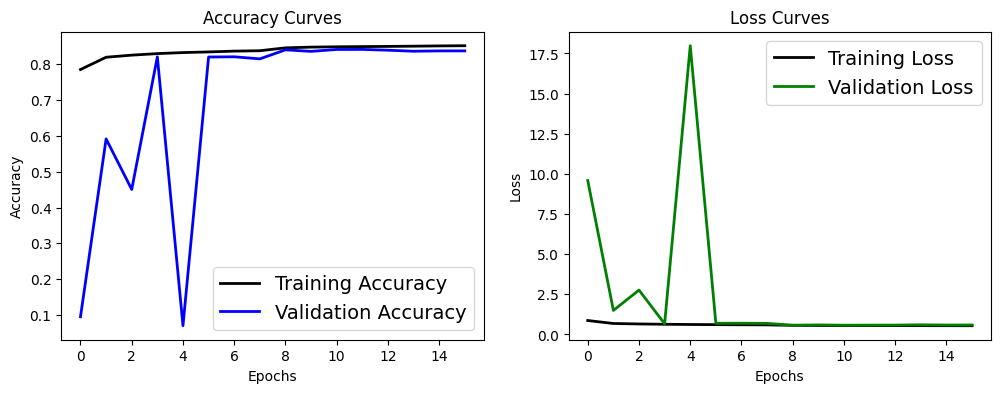

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_incep_2.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_incep_2.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_incep_2.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_incep_2.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

### Input 제외 모든 레이어 오픈

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, ZeroPadding2D,Flatten, Dropout
from tensorflow.keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

input_layer = Input(shape=(28, 28, 1))
pad_layer = ZeroPadding2D(padding=((61, 61), (61, 61)))(input_layer)
layer = tf.keras.layers.Concatenate()([pad_layer, pad_layer, pad_layer])

for i in range(20):
    base_model_layer = base_model.layers[i]
    layer = base_model_layer(layer)

x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(layer)
x = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(units=62, activation='softmax')(x)

model_inception = Model(inputs=input_layer, outputs=x)
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 150, 150, 1)  0          ['input_2[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 150, 150, 3)  0           ['zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]',         
                                                                  'zero_padding2d[0][0]']         
                                                                                              

In [ ]:
for layer in model_inception.layers[:-27]:
    layer.trainable = False
    print(layer)

In [ ]:
keras.backend.clear_session()
model_inception.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_dir = './model_inception_3_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

In [ ]:
start = time.time()
history_incep_3 = model_inception.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
train_time = time.time()-start

Epoch 1/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.8668 - accuracy: 0.7847
Epoch 1: val_loss improved from inf to 1.80521, saving model to ./model_inception_3_checkpoint\cp-01-1.8052.ckpt
4313/4313 [==============================] - 108s 25ms/step - loss: 0.8668 - accuracy: 0.7847 - val_loss: 1.8052 - val_accuracy: 0.5648 - lr: 0.0010
Epoch 2/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.8206
Epoch 2: val_loss did not improve from 1.80521
4313/4313 [==============================] - 108s 25ms/step - loss: 0.6779 - accuracy: 0.8206 - val_loss: 6.1479 - val_accuracy: 0.2094 - lr: 0.0010
Epoch 3/50
4312/4313 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.8266
Epoch 3: val_loss improved from 1.80521 to 0.76207, saving model to ./model_inception_3_checkpoint\cp-03-0.7621.ckpt
4313/4313 [==============================] - 108s 25ms/step - loss: 0.6476 - accuracy: 0.8266 - val_loss: 0.7621 - val_accuracy: 0.

In [ ]:
start = time.time()
print(model_inception.evaluate(X_test,y_test))

model_inception_test_time = time.time()-start
print("inference time : ", model_inception_test_time, "s")

2730/2730 [==============================] - 6s 2ms/step - loss: 0.6279 - accuracy: 0.8397
[0.6279031038284302, 0.8397362232208252]
inference time :  6.078124046325684 s


In [ ]:
model_inception.save("model_inceptionV5_3.h5")

Text(0.5, 1.0, 'Loss Curves')

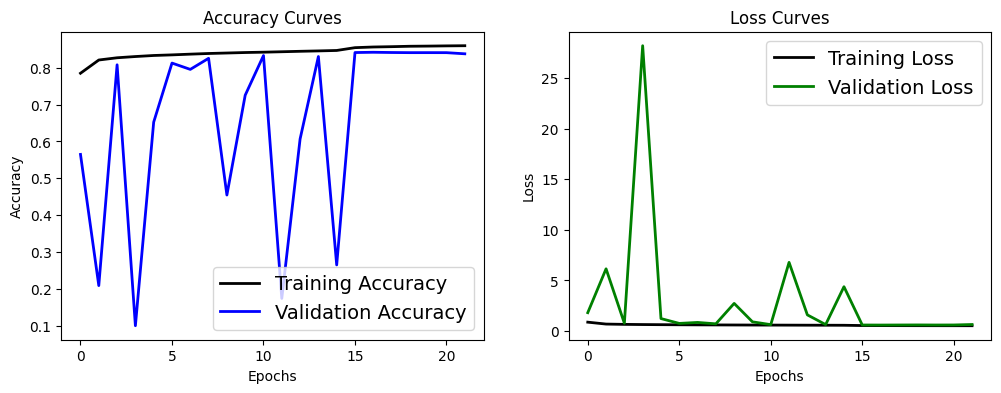

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history_incep_3.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(history_incep_3.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history_incep_3.history['loss'], 'black', linewidth=2.0)
ax2.plot(history_incep_3.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# New Model

In [ ]:
# CNN 인공신경망 정의
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, kernel_regularizer='l2', activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))
    
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
        
    return model

In [ ]:
p_model = create_model()
p_model.summary()

checkpoint_dir = './p_model_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:02d}-{val_loss:.4f}.ckpt'
MCP = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)
RLP = ReduceLROnPlateau(monitor='val_loss', patience=4, min_lr=1e-4)

callbacks_list = [ES, MCP, RLP]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_34 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_35 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [ ]:
start = time.time()
p_model_history = p_model.fit(X_train, y_train, epochs=50, batch_size=128,
                      verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)
p_model_train_time = time.time()-start

Epoch 1/50
4308/4313 [============================>.] - ETA: 0s - loss: 1.1054 - accuracy: 0.7735
Epoch 1: val_loss improved from inf to 0.77159, saving model to ./p_model_checkpoint\cp-01-0.7716.ckpt
4313/4313 [==============================] - 45s 10ms/step - loss: 1.1050 - accuracy: 0.7735 - val_loss: 0.7716 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 2/50
4309/4313 [============================>.] - ETA: 0s - loss: 0.7980 - accuracy: 0.8107
Epoch 2: val_loss improved from 0.77159 to 0.73452, saving model to ./p_model_checkpoint\cp-02-0.7345.ckpt
4313/4313 [==============================] - 44s 10ms/step - loss: 0.7980 - accuracy: 0.8108 - val_loss: 0.7345 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 3/50
4310/4313 [============================>.] - ETA: 0s - loss: 0.7666 - accuracy: 0.8175
Epoch 3: val_loss improved from 0.73452 to 0.71667, saving model to ./p_model_checkpoint\cp-03-0.7167.ckpt
4313/4313 [==============================] - 44s 10ms/step - loss: 0.7666 - accuracy: 0.8175 

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
p_model.load_weights(latest)
start = time.time()
p_model.evaluate(X_test, y_test, verbose=0)

[0.5727828741073608, 0.845707356929779]

In [ ]:
p_model.save("model_per.h5")

In [ ]:
y_test_hand[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
from tensorflow import keras
p_model= keras.models.load_model("model_per.h5")

In [ ]:
p_model.evaluate(X_test,y_test_hand)

78/78 [==============================] - 1s 7ms/step - loss: 0.8146 - accuracy: 0.7101


[0.814562201499939, 0.710080623626709]

Text(0.5, 1.0, 'Loss Curves')

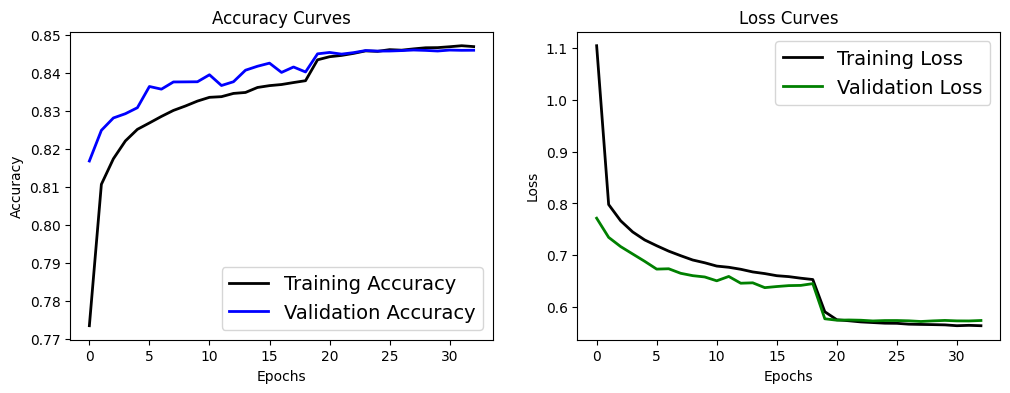

In [ ]:
# Accuracy curve
plt.figure(figsize=[12,4])
ax1 = plt.subplot(1, 2, 1)
ax1.plot(p_model_history.history['accuracy'], 'black', linewidth=2.0)
ax1.plot(p_model_history.history['val_accuracy'], 'blue', linewidth=2.0)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Loss curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(p_model_history.history['loss'], 'black', linewidth=2.0)
ax2.plot(p_model_history.history['val_loss'], 'green', linewidth=2.0)
ax2.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# confusion matrix
def plot_confusion_matrix(cm, class_names, figsize=(8, 8)):
    cm = cm.numpy()
    figure = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

s_alph=list(string.ascii_lowercase)
l_alph=list(string.ascii_uppercase)
number = [str(i) for i in range(10)]
byclass_clss=np.transpose(number+l_alph+s_alph)

4313/4313 [==============================] - 7s 2ms/step


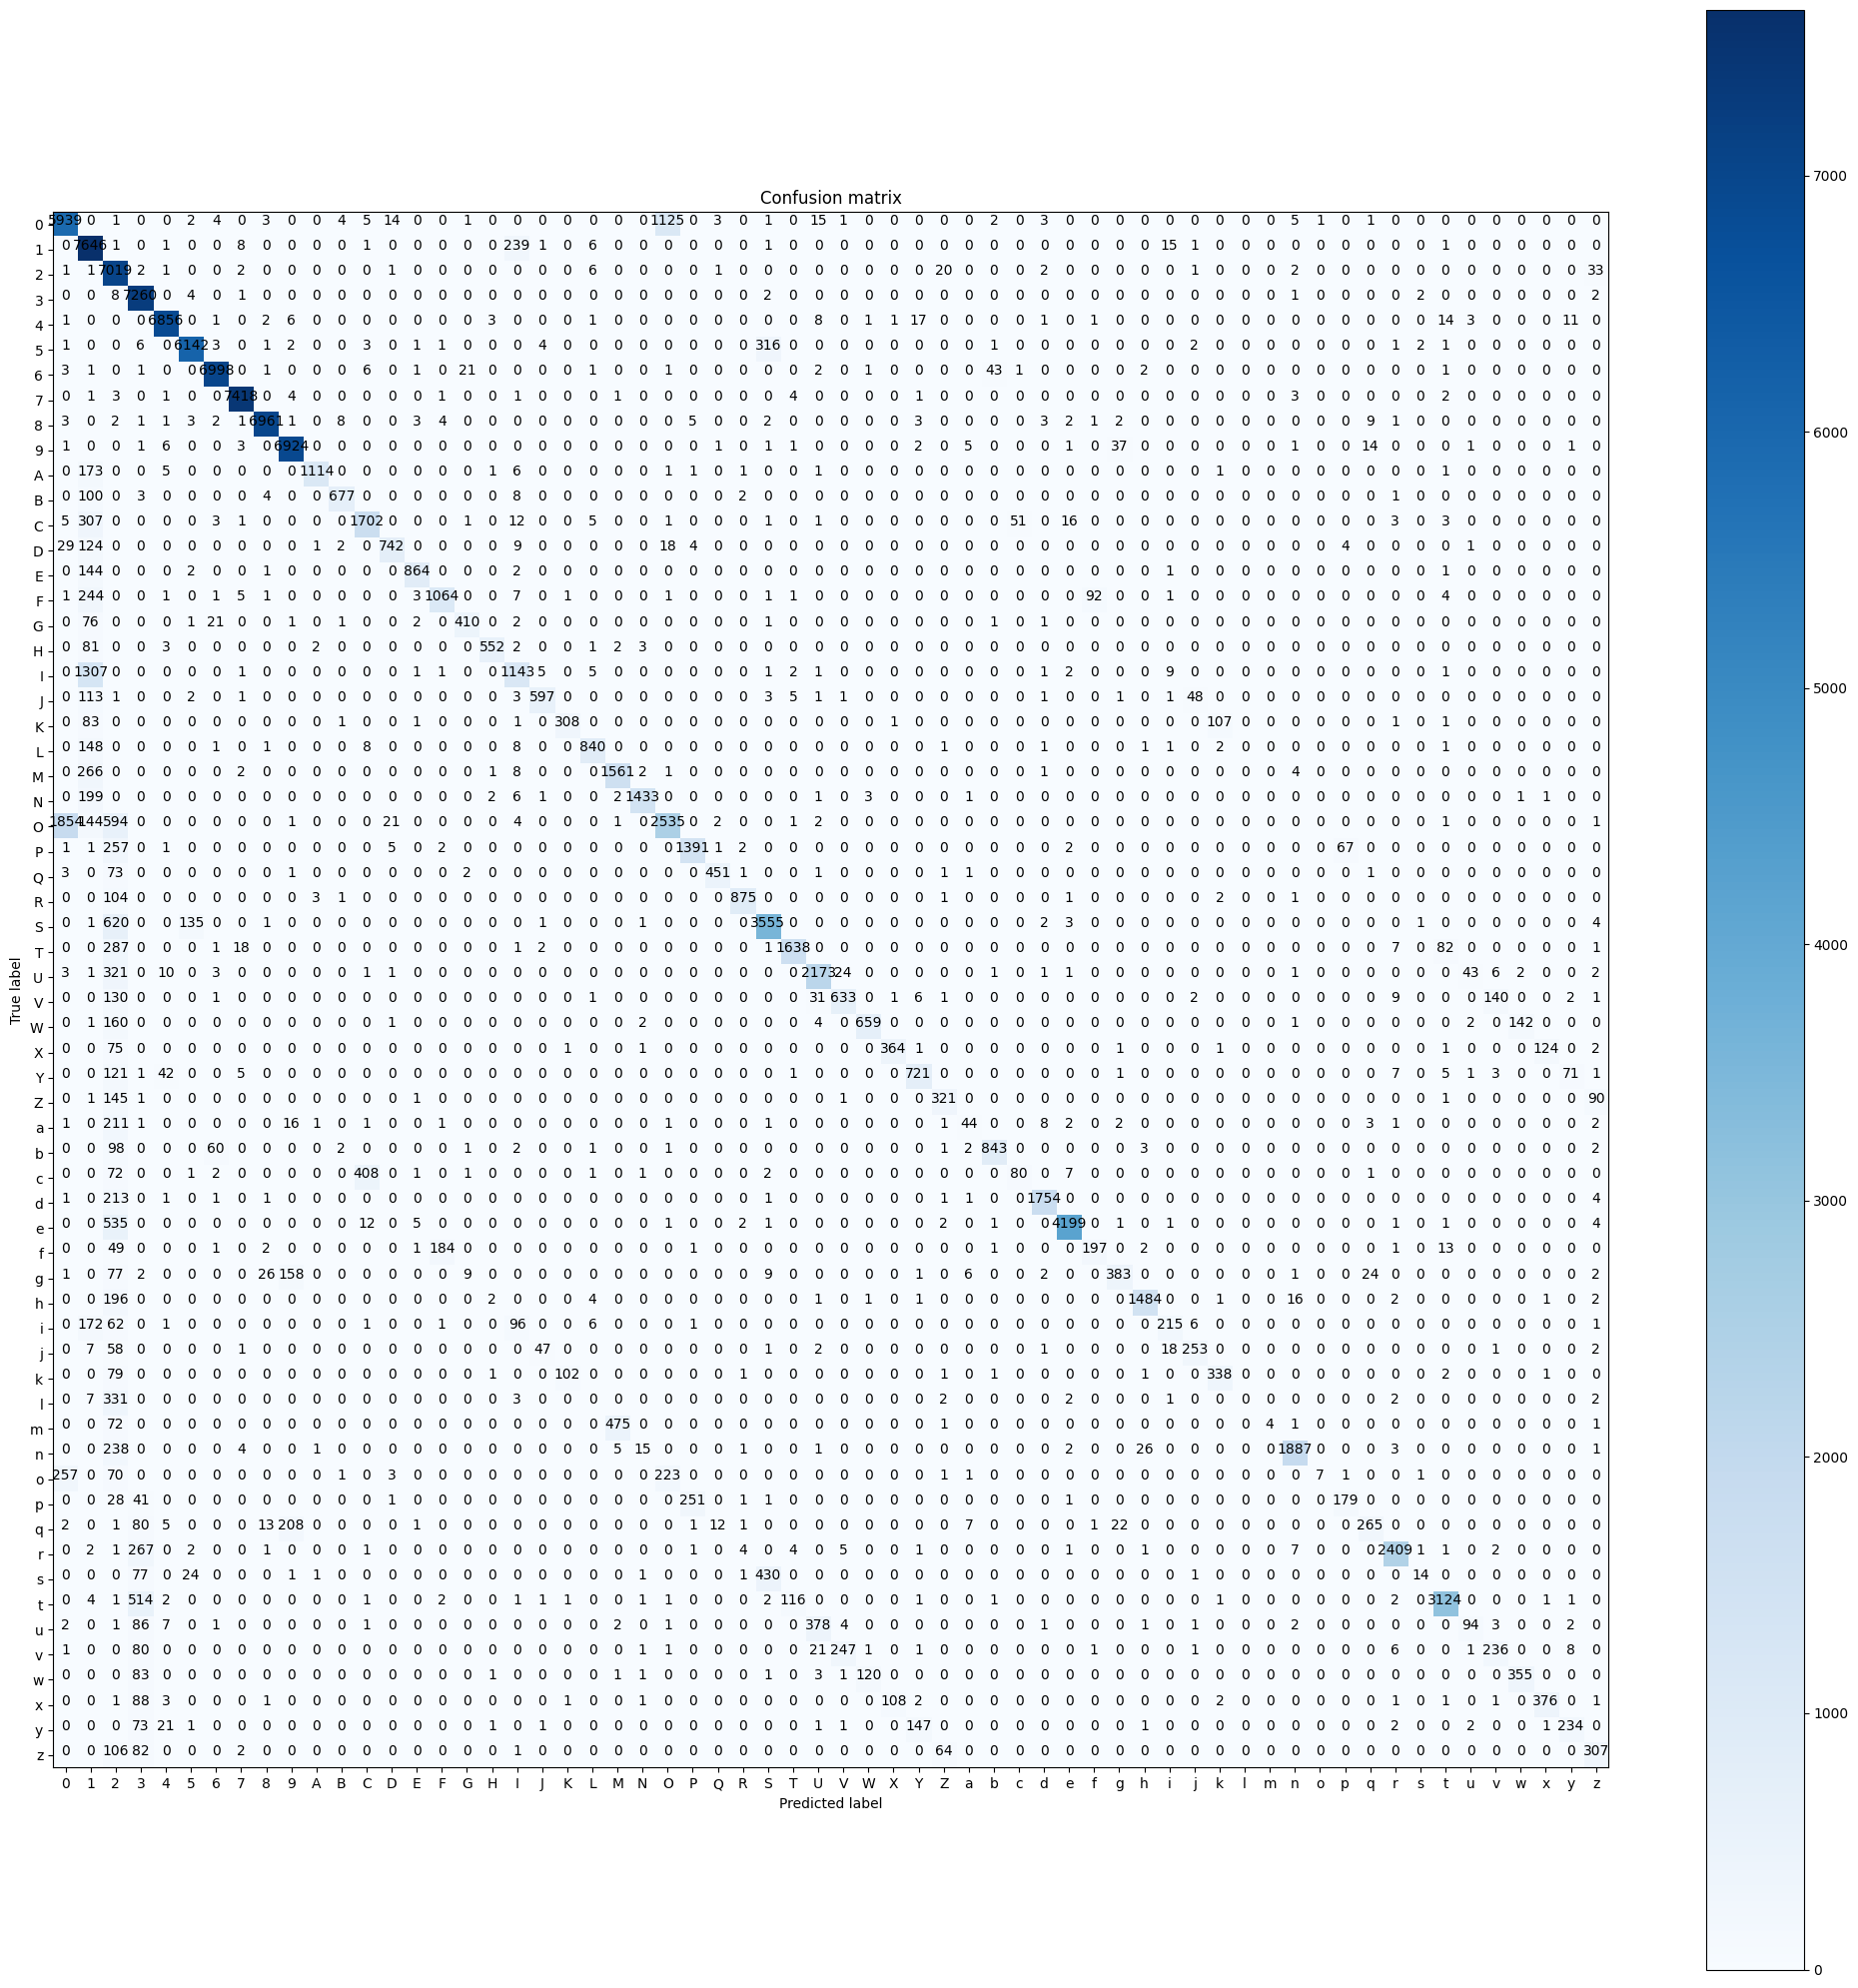

In [ ]:
y_pred=p_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_val, axis = 1)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)
fig = plot_confusion_matrix(confusion_mtx, byclass_clss, figsize=(20, 20))